In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import mutual_info_regression
from statsmodels.tsa.stattools import adfuller, kpss, ccf
import ppscore as pps

import holidays

from estimate_probability import (
    add_index,
    expanding_window_cross_validation,
    score,
    template_single_column,
    estimate_probability,
)

In [2]:
# Path to data directory
data_dir = Path('./data')

In [3]:
# US holidays
us_holidays = holidays.US()

# Data Loading, Processing & Analysis

## Load
Read and inspect the file containing the electricity load.

In [4]:
load = pd.read_csv(
    data_dir / "load_hist_data.csv"
)

In [5]:
load = add_index(load)

In [6]:
load.head()

Date  Hour  Load
Datetime                                  
2005-01-01 00:00:00 2005-01-01     1   857
2005-01-01 01:00:00 2005-01-01     2   825
2005-01-01 02:00:00 2005-01-01     3   800
2005-01-01 03:00:00 2005-01-01     4   794
2005-01-01 04:00:00 2005-01-01     5   802

In [7]:
load.tail()

Date  Hour  Load
Datetime                                  
2007-12-31 19:00:00 2007-12-31    20  1269
2007-12-31 20:00:00 2007-12-31    21  1255
2007-12-31 21:00:00 2007-12-31    22  1237
2007-12-31 22:00:00 2007-12-31    23  1212
2007-12-31 23:00:00 2007-12-31    24  1174

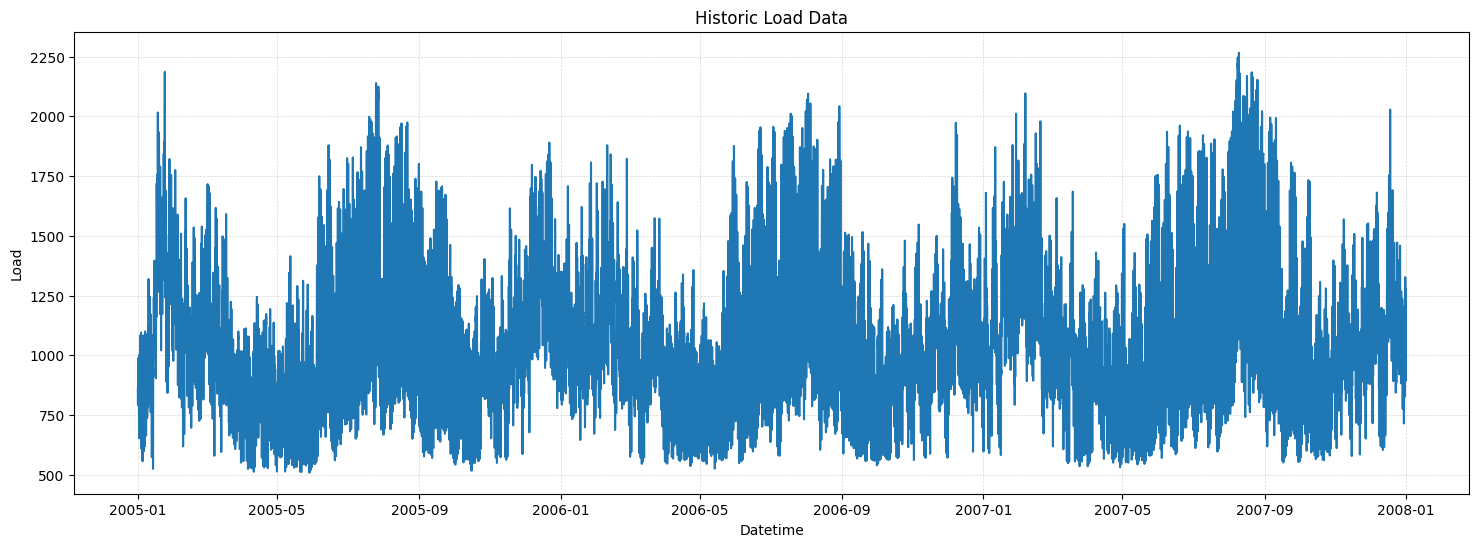

In [8]:
fig, ax = plt.subplots(figsize=(18, 6))

sns.lineplot(data=load, x=load.index, y="Load", ax=ax)

ax.set_title('Historic Load Data')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)

In [9]:
# Check Nan values
print(f"Nans: {load['Load'].isna().sum()}")

Nans: 0


In [10]:
# Check for missing datetimes
load_full_range = pd.date_range(start=load.index.min(), end=load.index.max(), freq="h")
load_missing_datetimes = load_full_range.difference(load.index)
print(f"Missing datetimes: {load_missing_datetimes}")
# Daylight Saving Time (DST) transition

Missing datetimes: DatetimeIndex(['2005-04-03 01:00:00', '2006-04-02 01:00:00',
               '2007-03-11 01:00:00'],
              dtype='datetime64[ns]', freq=None)


In [11]:
# Check for duplicated datetimes
load_duplicated_datetimes = load.index[load.index.duplicated()]
print(f"Duplicated datetimes: {load_duplicated_datetimes}")
# Daylight Saving Time (DST) transition

Duplicated datetimes: DatetimeIndex(['2005-10-30 01:00:00', '2006-10-29 01:00:00',
               '2007-11-04 01:00:00'],
              dtype='datetime64[ns]', name='Datetime', freq=None)


In [12]:
# Get description of the data
load.describe().T

count                           mean                  min  \
Date    26280  2006-07-02 00:36:03.287671168  2005-01-01 00:00:00   
Hour  26280.0                           12.5                  1.0   
Load  26280.0                    1071.858866                509.0   

                      25%                  50%                  75%  \
Date  2005-10-01 00:00:00  2006-07-02 00:00:00  2007-04-02 00:00:00   
Hour                 6.75                 12.5                18.25   
Load                854.0               1009.0               1252.0   

                      max         std  
Date  2007-12-31 00:00:00         NaN  
Hour                 24.0    6.922318  
Load               2266.0  313.951126

### Add peak feature

In [13]:
# Add peak load flag
load["is_peak"] = load.groupby("Date")["Load"].transform(lambda x: x == x.max()).astype(int)

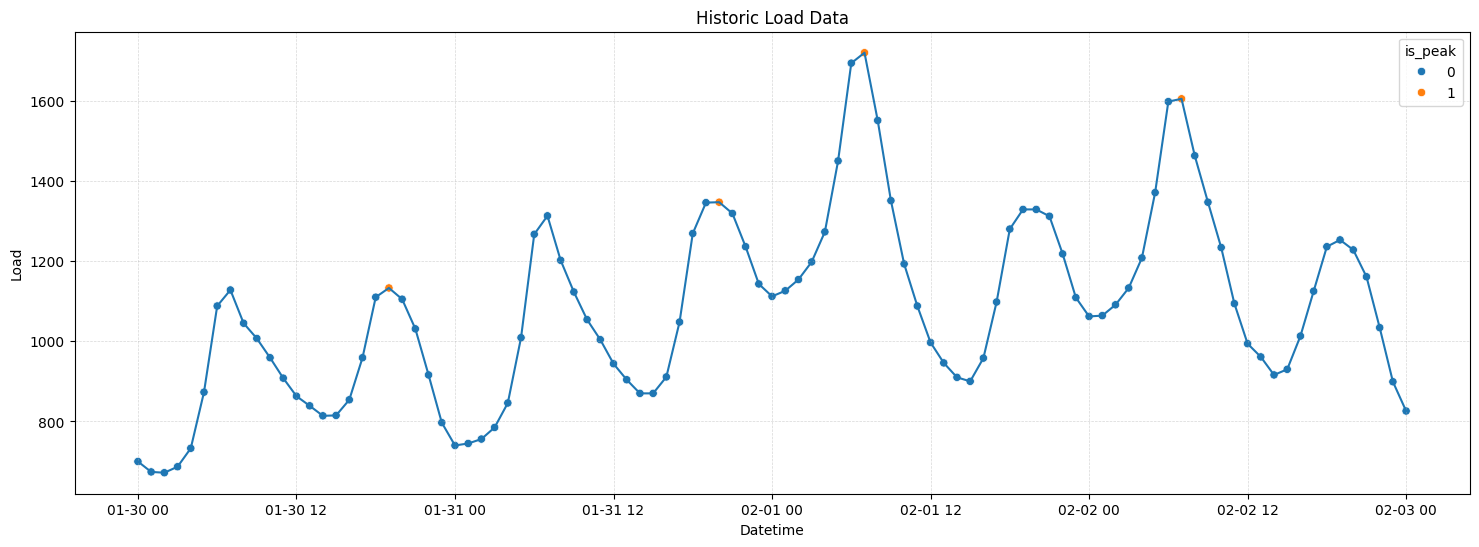

In [14]:
fig, ax = plt.subplots(figsize=(18, 6))

central_date = pd.to_datetime("2006-02-01")
delta = pd.Timedelta("2D")

sns.lineplot(
    data=load[central_date - delta : central_date + delta],
    x=load[central_date - delta : central_date + delta].index,
    y="Load",
    ax=ax,
)
sns.scatterplot(
    data=load[central_date - delta : central_date + delta],
    x=load[central_date - delta : central_date + delta].index,
    y="Load",
    hue="is_peak",
    ax=ax,
)

ax.set_title("Historic Load Data")
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)

## Load Time Series Analysis
Inspect the properties of the time series.

In [15]:
load_analysis = load.copy()

load_analysis["Day"] = load_analysis.index.day.astype("int")
load_analysis["Dayofweek"] = load_analysis.index.dayofweek.astype("int")
load_analysis["Dayofyear"] = load_analysis.index.dayofyear.astype("int")
load_analysis["Week"] = load_analysis.index.isocalendar().week.astype("int")
load_analysis["Month"] = load_analysis.index.month.astype("int")
load_analysis["Quarter"] = load_analysis.index.quarter.astype("int")
load_analysis["Year"] = load_analysis.index.year.astype("int")
load_analysis["Holiday"] = [
    1 if date in us_holidays else 0 for date in load_analysis.index.date
]

### Stationarity

In [16]:
window = 24*4
rolling = load_analysis["Load"].rolling(window=window)
load_analysis[f"rolling_{window}_Load_mean"] = rolling.mean()
load_analysis[f"rolling_{window}_Load_std"] = rolling.std()

Text(0.5, 1.0, 'Load Data - Rolling 96h Std')

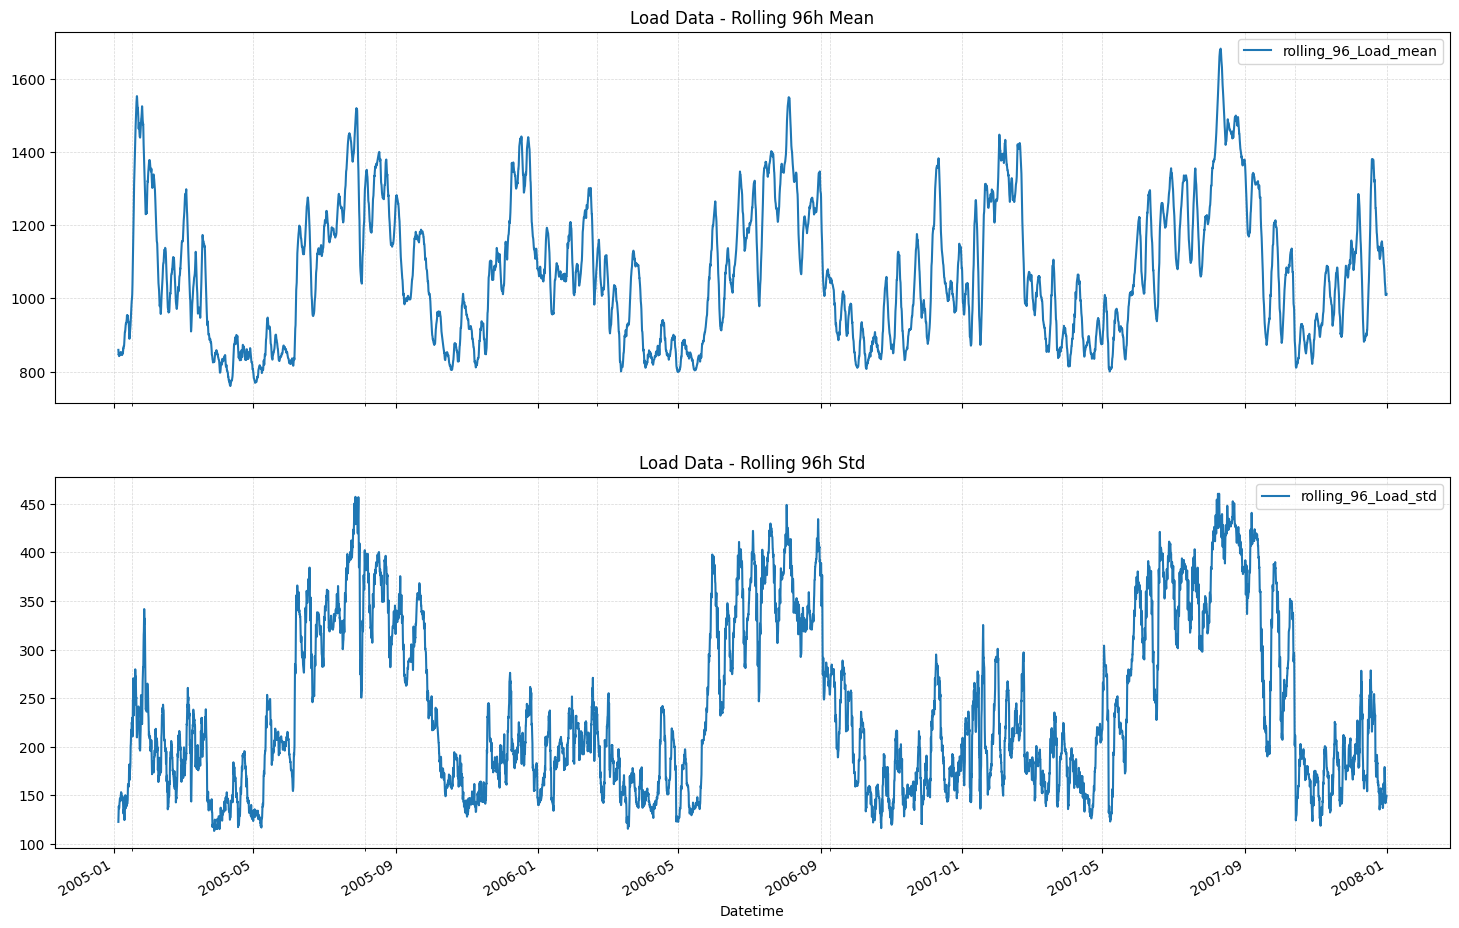

In [17]:
fig, ax = plt.subplots(2,1, figsize=(18, 12), sharex=True)

load_analysis.plot(y=f"rolling_{window}_Load_mean", ax=ax[0])
load_analysis.plot(y=f"rolling_{window}_Load_std", ax=ax[1])

for axi in ax:
    axi.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)  

ax[0].set_title(f"Load Data - Rolling {window}h Mean")
ax[1].set_title(f"Load Data - Rolling {window}h Std")

In [18]:
adf_result = adfuller(load_analysis["Load"])
kpss_result = kpss(load_analysis["Load"], regression="c")

In [19]:
print("ADF Test:")
print(f"p-value: {adf_result[1]}")

ADF Test:
p-value: 3.570296265382238e-16


In [20]:
print("\nKPSS Test:")
print(f"p-value: {kpss_result[1]}")


KPSS Test:
p-value: 0.030921686279883877


The series is stationary (p>0.05) for the ADF test, but not for the KPSS Test (close to 0.05). There is a clear difference in the Summer/Winter load profiles, both in the value and in the variability.

### Monthly average week profiles
Inspect the average profiles of the time series.

In [21]:

week_profiles = template_single_column(
    load_analysis,
    "Load",
    ["Year", "Month", "Dayofweek", "Hour"],
    methods=["mean", "std"],
    change_col_names=True,
)

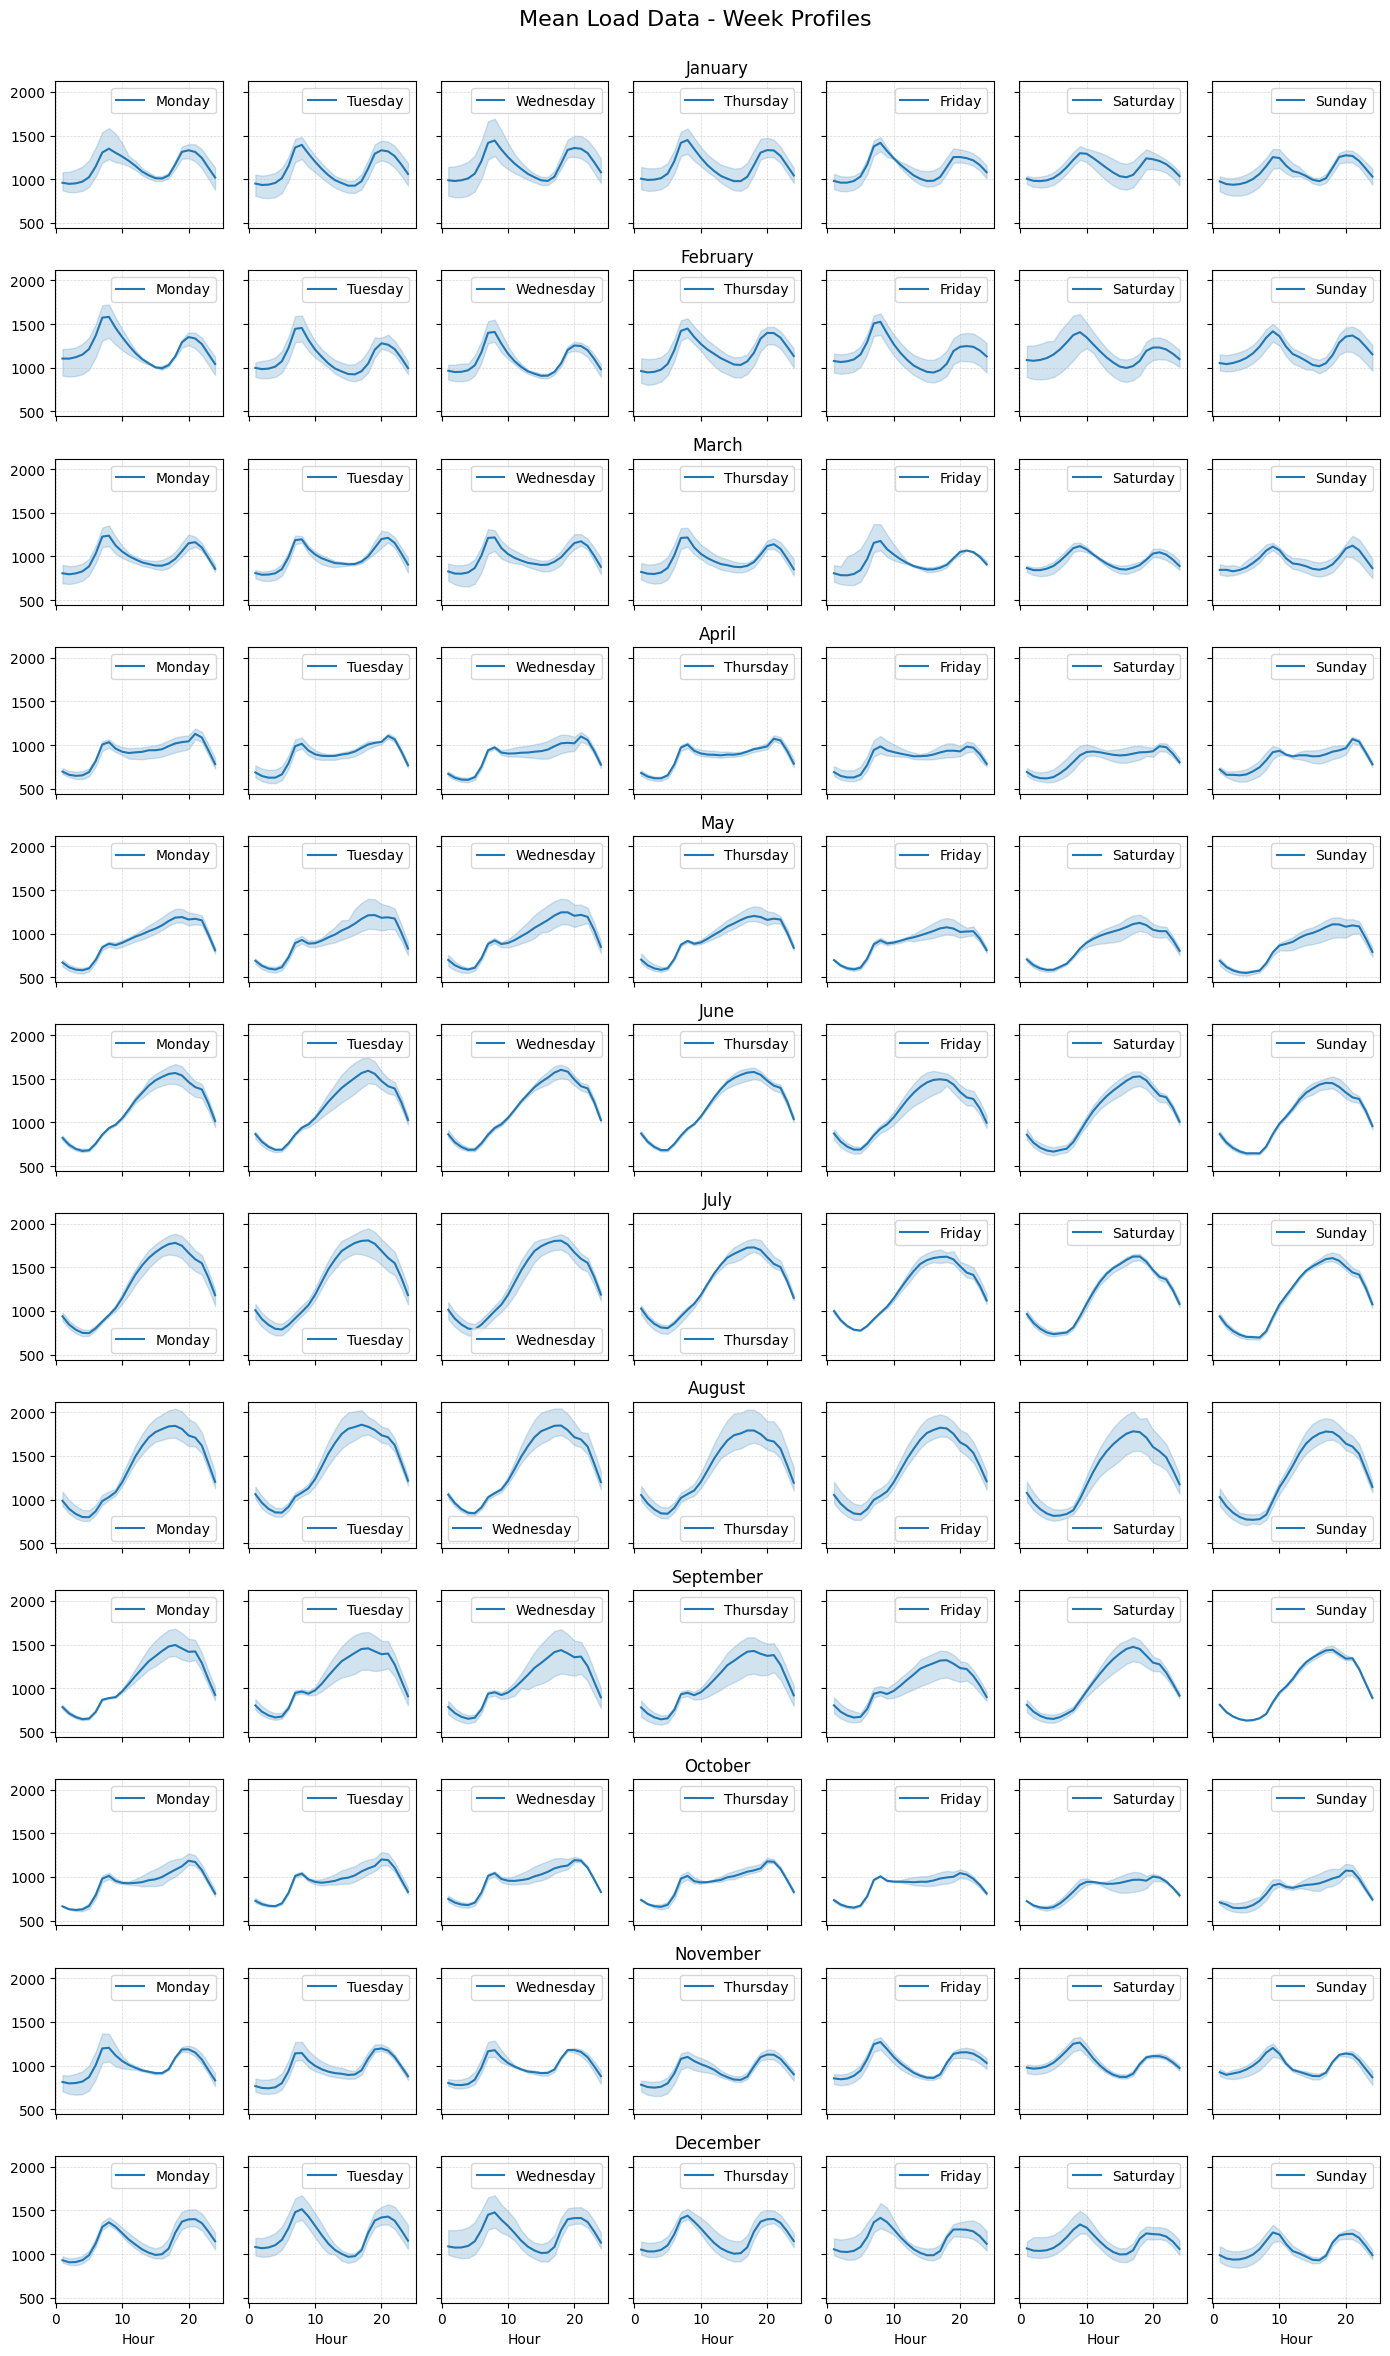

In [22]:
fig, ax = plt.subplots(12, 7, figsize=(14, 24), sharex=True, sharey=True)

days = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday",
}
months = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December",
}

for month, month_df in week_profiles.groupby("Month"):
    row = int(month - 1)
    for day, day_df in month_df.groupby("Dayofweek"):
        column = int(day)
        axi = ax[row][column]
        if column == 3:
            axi.set_title(f"{months[month]}")
        sns.lineplot(
            data=day_df, x="Hour", y="Load_tmpl_mean", ax=axi, label=f"{days[day]}"
        )
        axi.grid(True, which="major", linestyle="--", linewidth=0.5, alpha=0.5)
    ax[row][0].set_ylabel("")


fig.suptitle("Mean Load Data - Week Profiles", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.98])


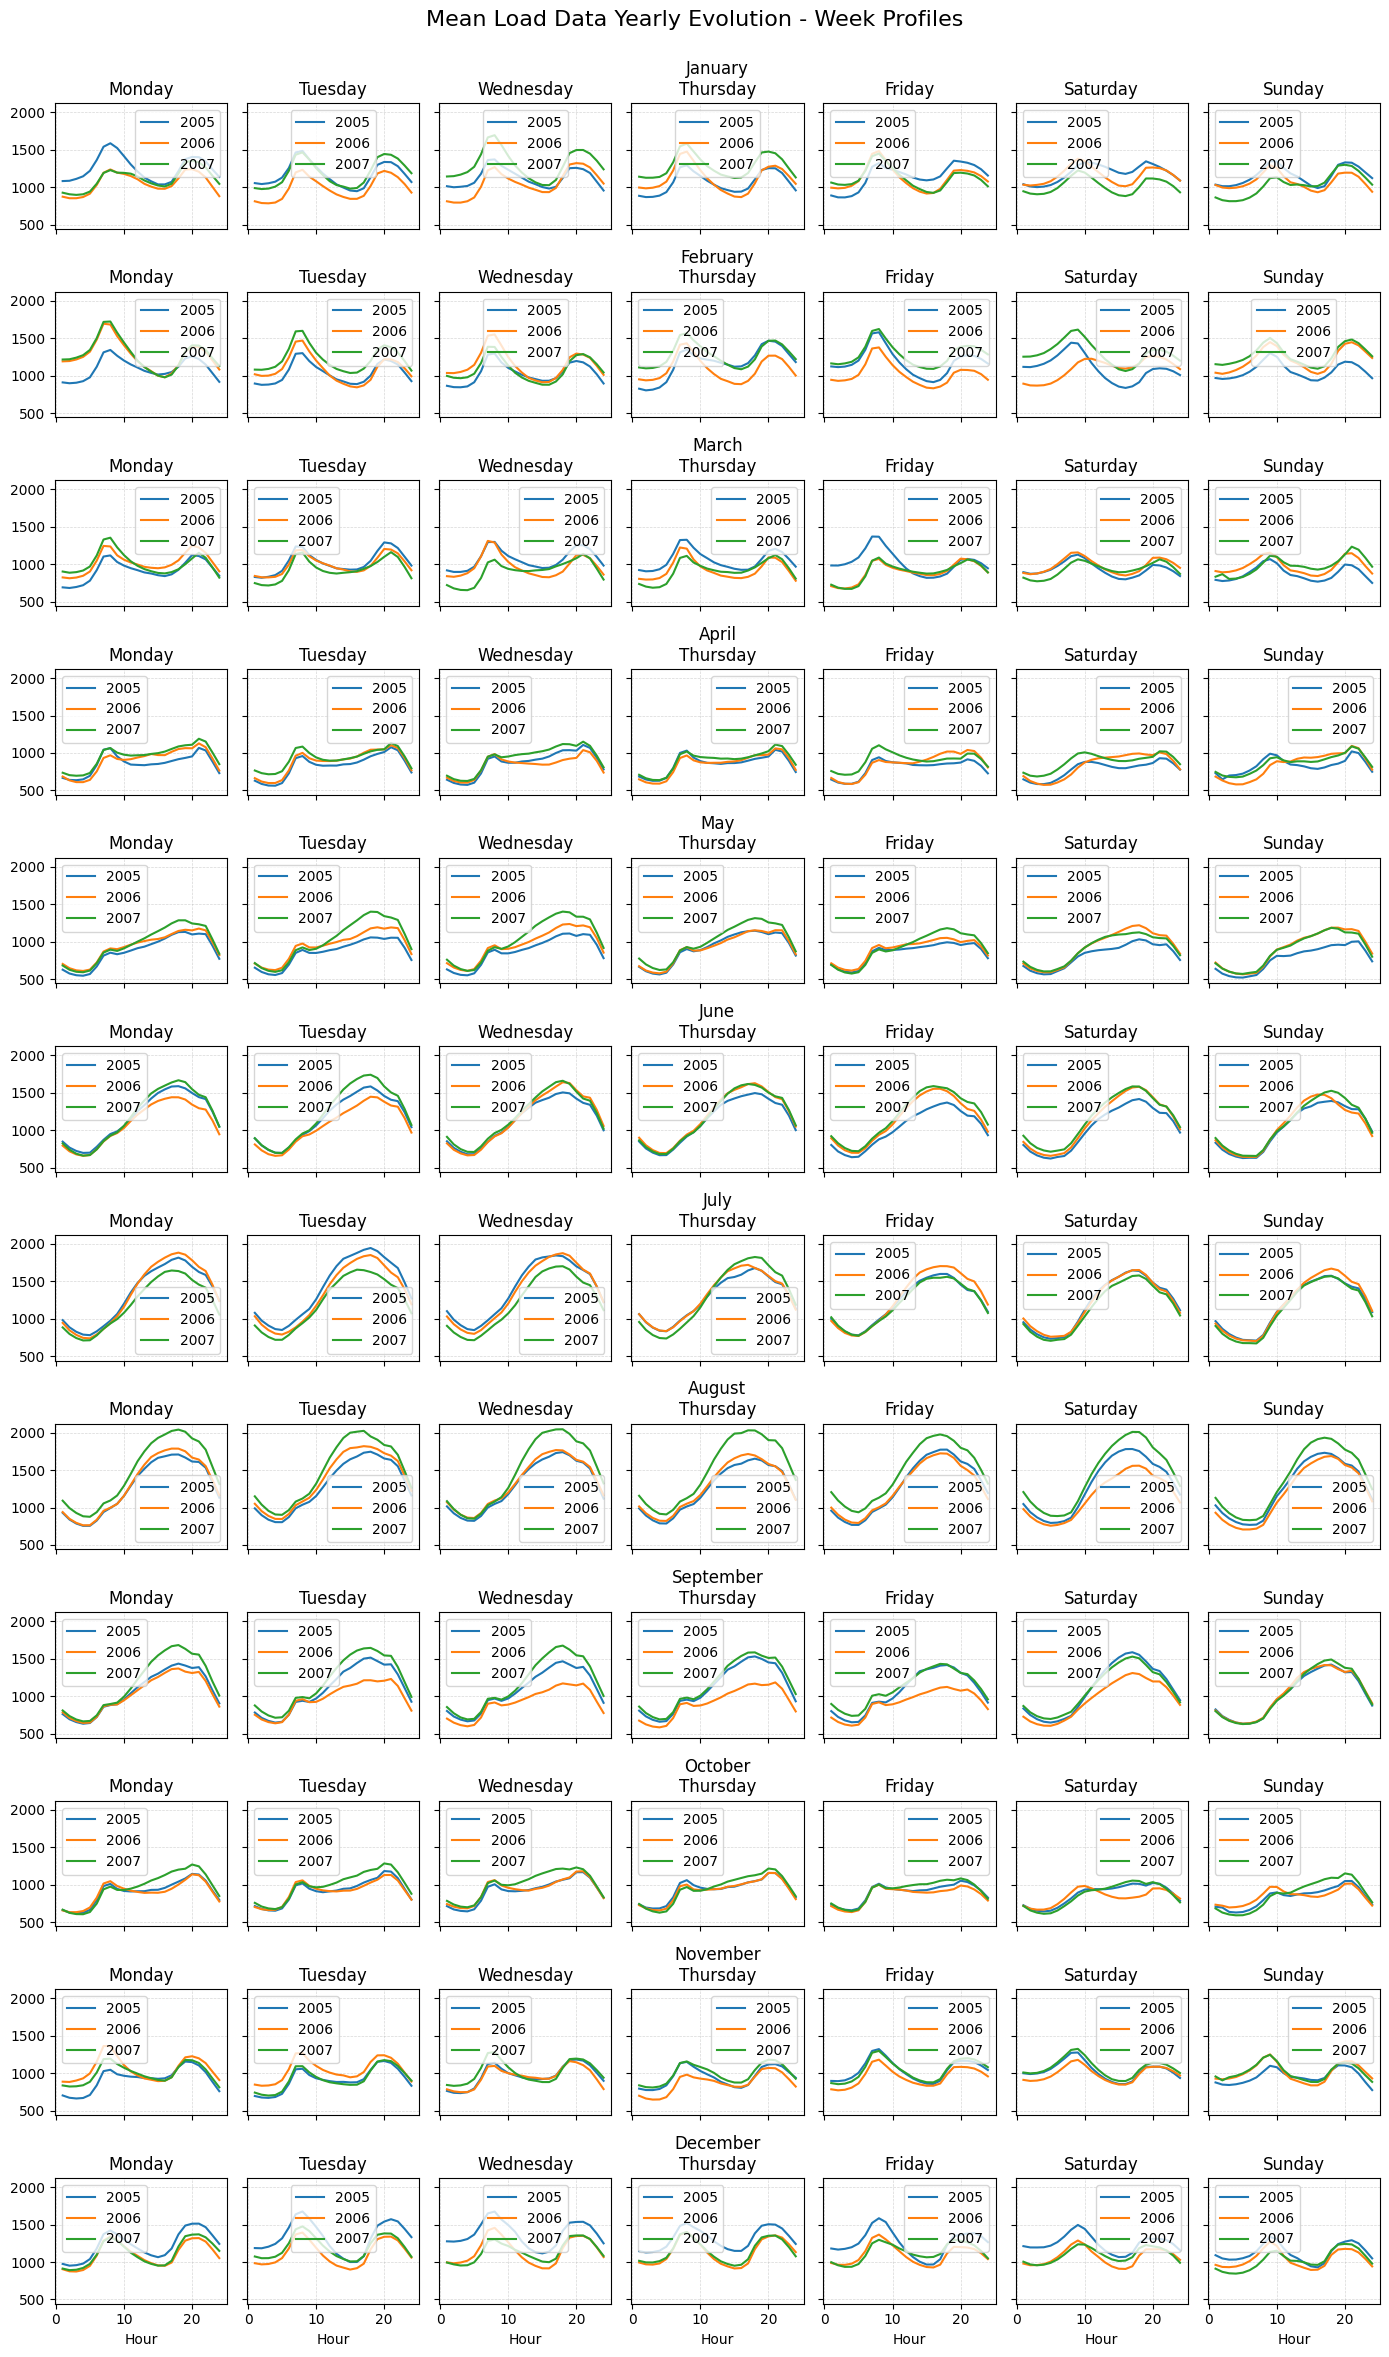

In [23]:
fig, ax = plt.subplots(12,7, figsize=(14, 24), sharex=True, sharey=True)

days = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday",
}
months = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December",
}

for year, year_df in week_profiles.groupby("Year"):
    for month, month_df in year_df.groupby("Month"):
        row = int(month-1)
        for day, day_df in month_df.groupby("Dayofweek"):
            column = int(day)
            axi = ax[row][column]
            axi.set_title(f"{days[day]}")
            if column == 3:
                axi.set_title(f"{months[month]}\n{days[day]}")
            sns.lineplot(data=day_df, x="Hour", y="Load_tmpl_mean", ax=axi, label=f"{year}")
            axi.grid(True, which="major", linestyle="--", linewidth=0.5, alpha=0.5)
        ax[row][0].set_ylabel("")


fig.suptitle("Mean Load Data Yearly Evolution - Week Profiles", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.98])

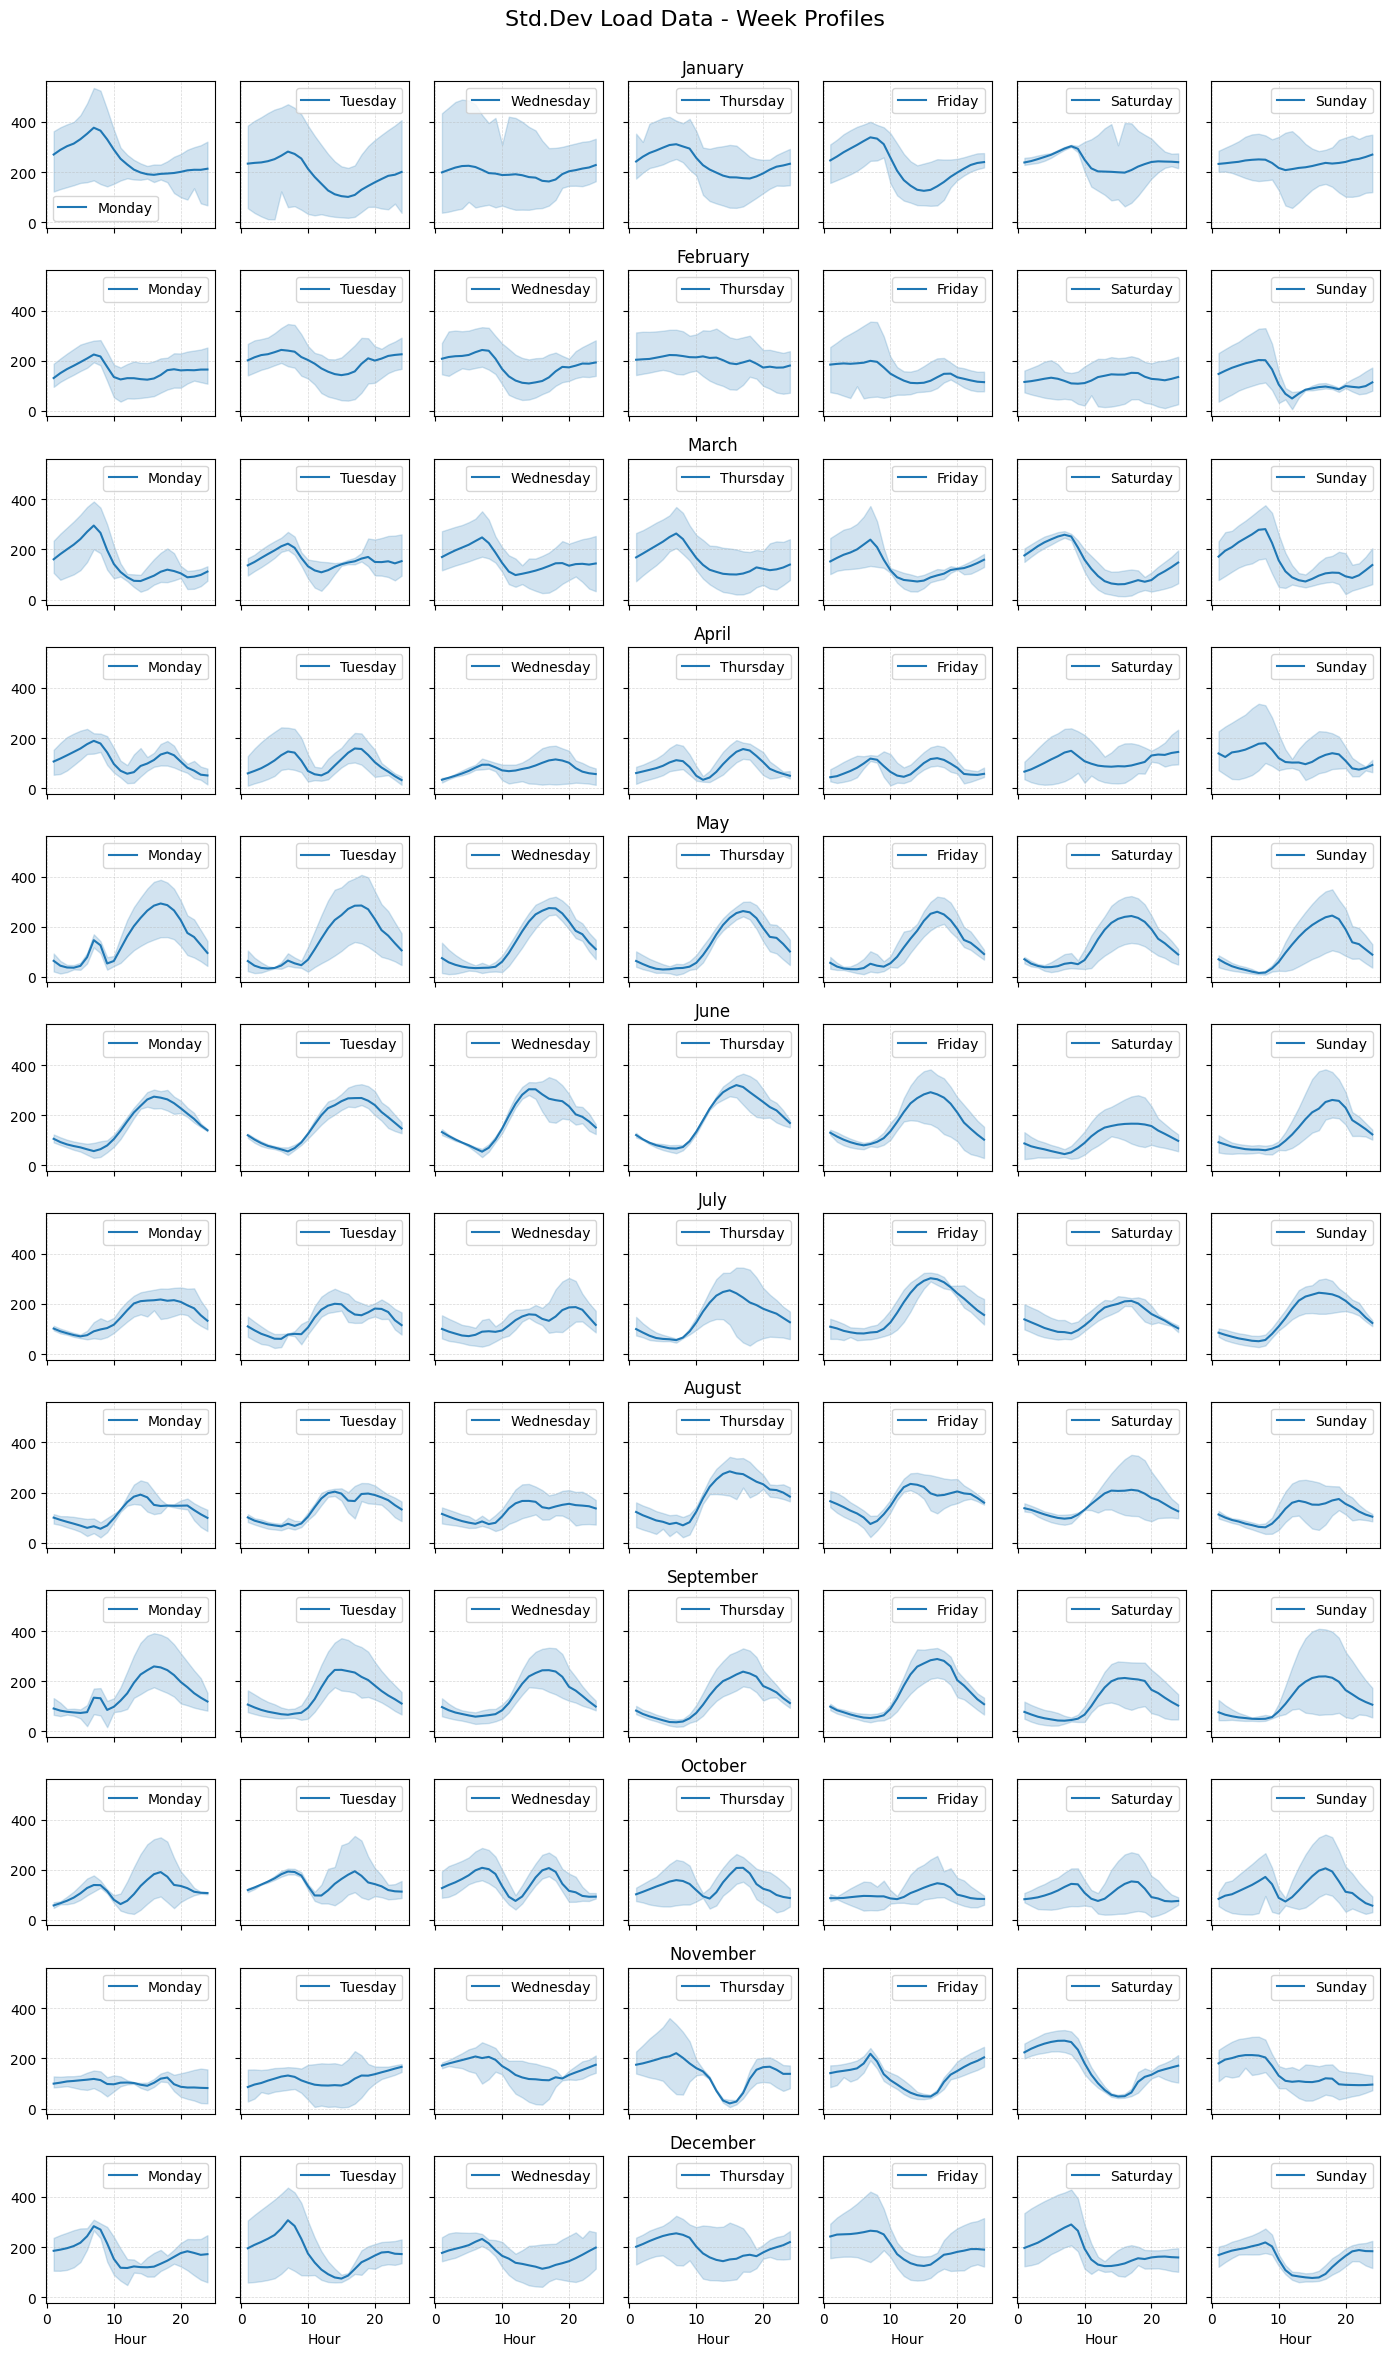

In [24]:
fig, ax = plt.subplots(12, 7, figsize=(14, 24), sharex=True, sharey=True)

days = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday",
}
months = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December",
}

for month, month_df in week_profiles.groupby("Month"):
    row = int(month - 1)
    for day, day_df in month_df.groupby("Dayofweek"):
        column = int(day)
        axi = ax[row][column]
        if column == 3:
            axi.set_title(f"{months[month]}")
        sns.lineplot(
            data=day_df, x="Hour", y="Load_tmpl_std", ax=axi, label=f"{days[day]}"
        )
        axi.grid(True, which="major", linestyle="--", linewidth=0.5, alpha=0.5)
    ax[row][0].set_ylabel("")


fig.suptitle("Std.Dev Load Data - Week Profiles", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.98])


In [25]:
week_profiles_peaks = template_single_column(
    load_analysis,
    "is_peak",
    ["Year", "Month", "Dayofweek", "Hour"],
    methods=["mean", "std"],
    change_col_names=True,
)

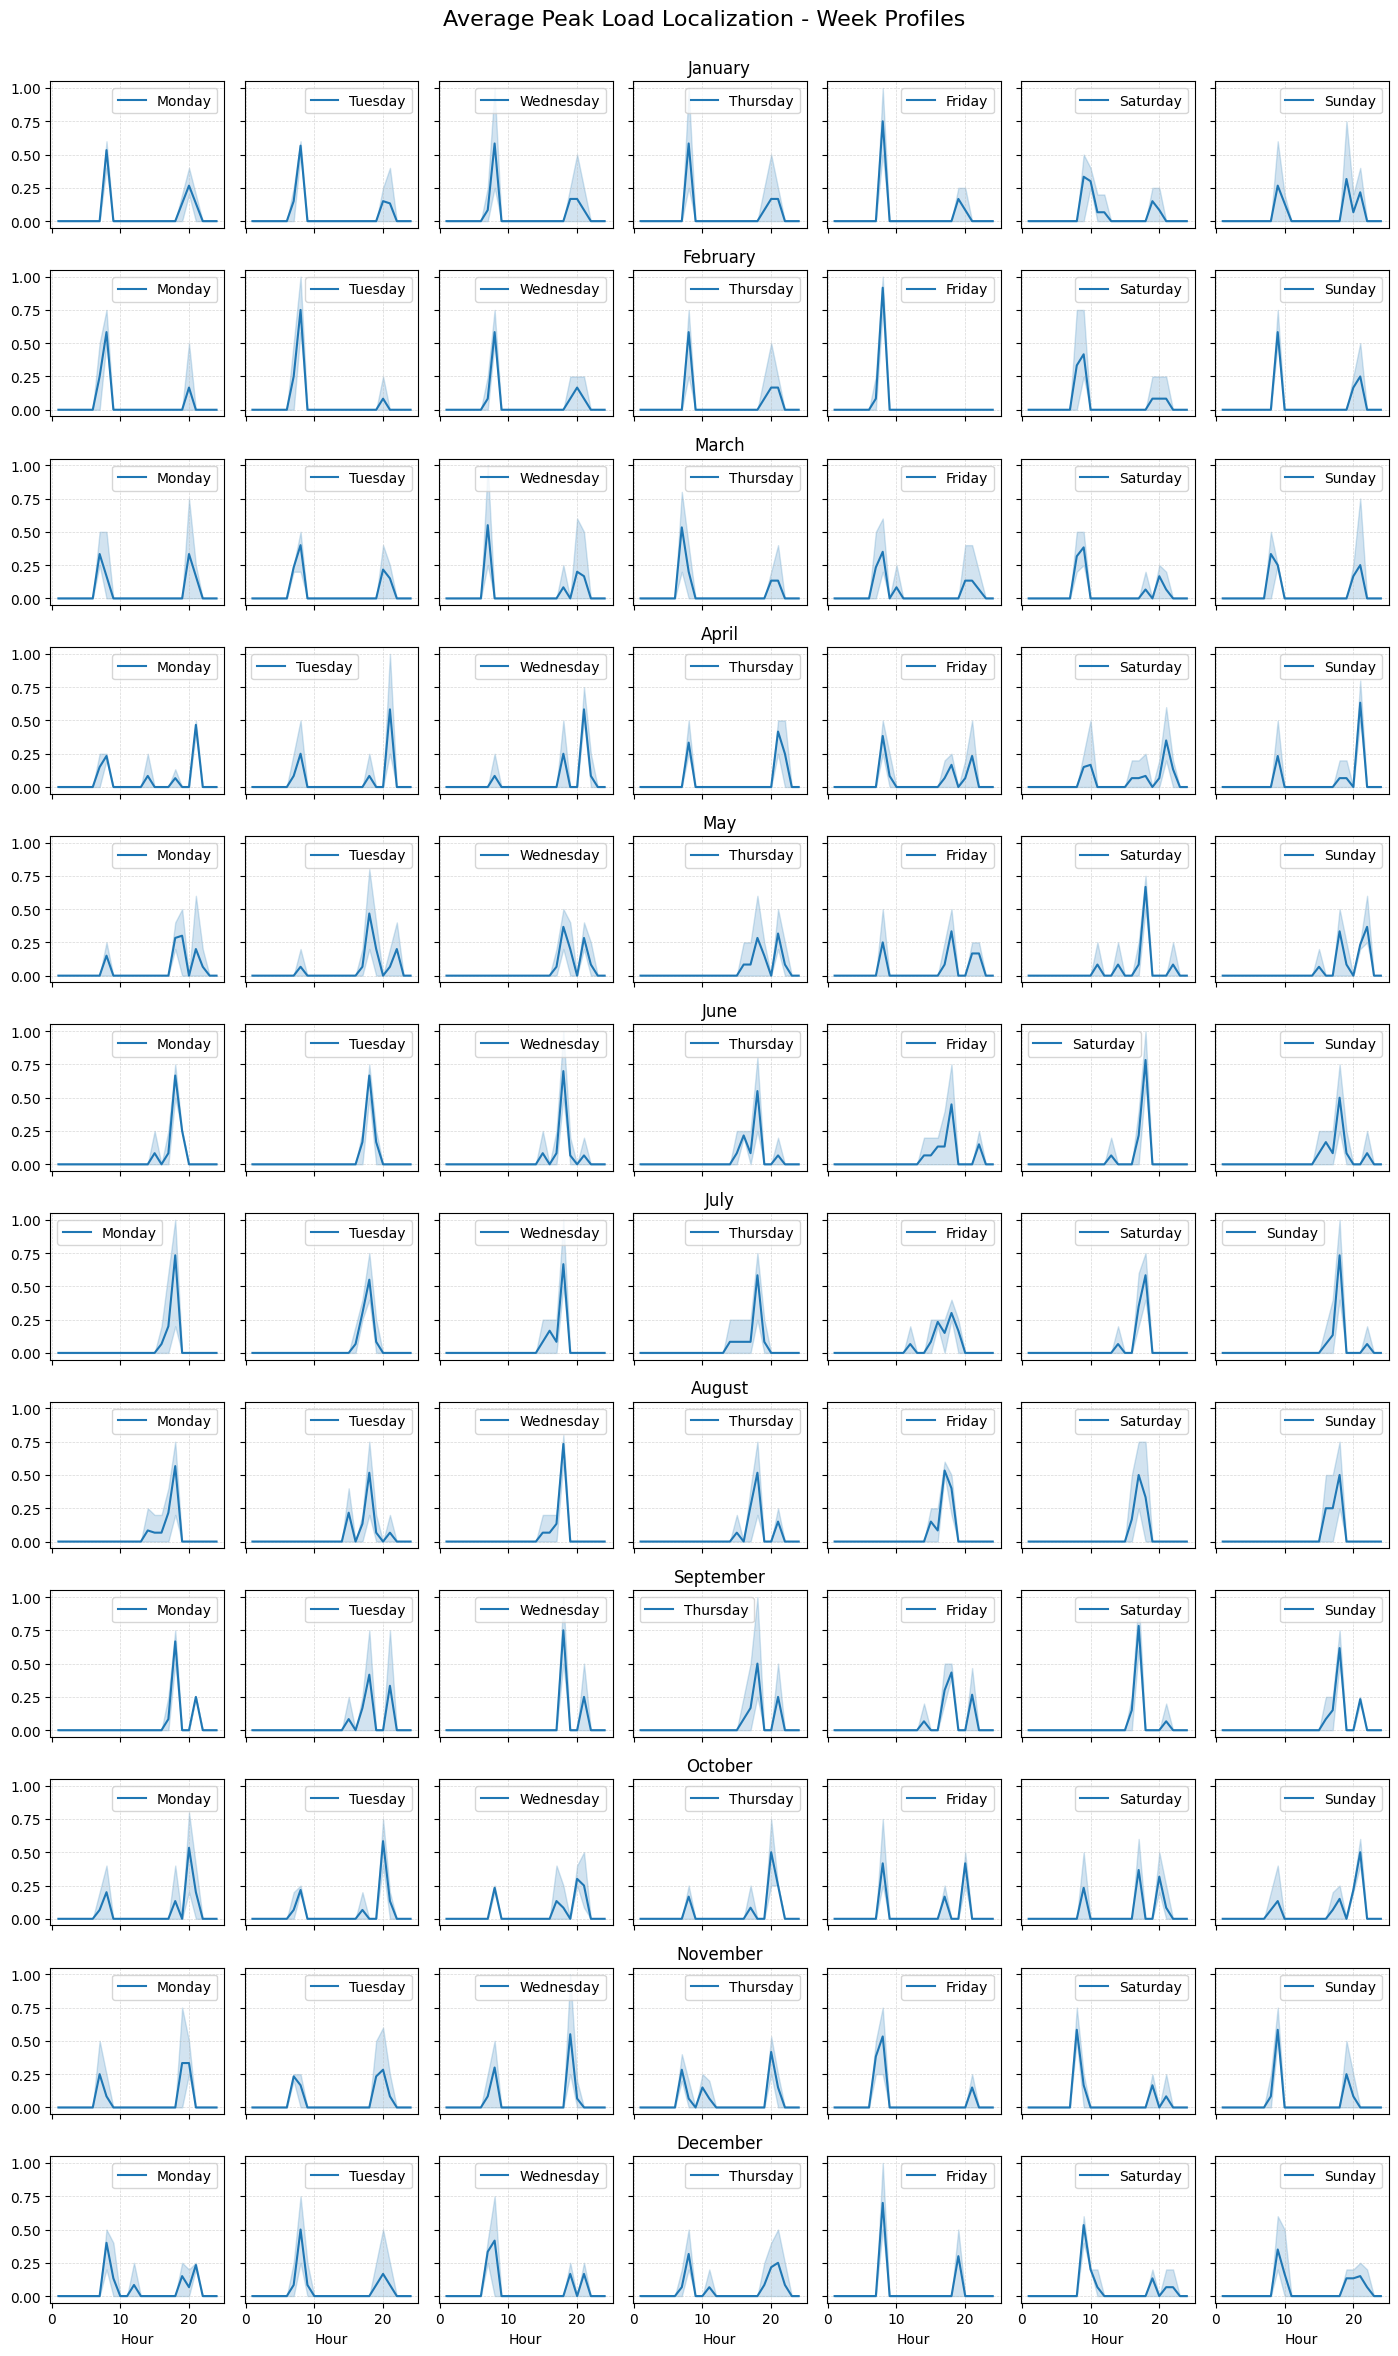

In [26]:
fig, ax = plt.subplots(12, 7, figsize=(14, 24), sharex=True, sharey=True)

days = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday",
}
months = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December",
}

for month, month_df in week_profiles_peaks.groupby("Month"):
    row = int(month - 1)
    for day, day_df in month_df.groupby("Dayofweek"):
        column = int(day)
        axi = ax[row][column]
        if column == 3:
            axi.set_title(f"{months[month]}")
        sns.lineplot(
            data=day_df, x="Hour", y="is_peak_tmpl_mean", ax=axi, label=f"{days[day]}"
        )
        axi.grid(True, which="major", linestyle="--", linewidth=0.5, alpha=0.5)
    ax[row][0].set_ylabel("")


fig.suptitle("Average Peak Load Localization - Week Profiles", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.98])


## Weather
Inspect the data from the weather stations.

In [27]:
weather = pd.read_csv(data_dir / 'weather_data.csv')

In [28]:
weather = add_index(weather)

In [29]:
# Switch to a more practical data format
weather_pivot = (
    add_index(weather)
    .reset_index()
    .pivot_table(index="Datetime", columns="Station ID", values="Temperature")
)
# Small approximation: duplicated values are replaced with the mean of the duplicates ()

In [30]:
weather_pivot.columns = [f"Station {col}" for col in weather_pivot.columns]

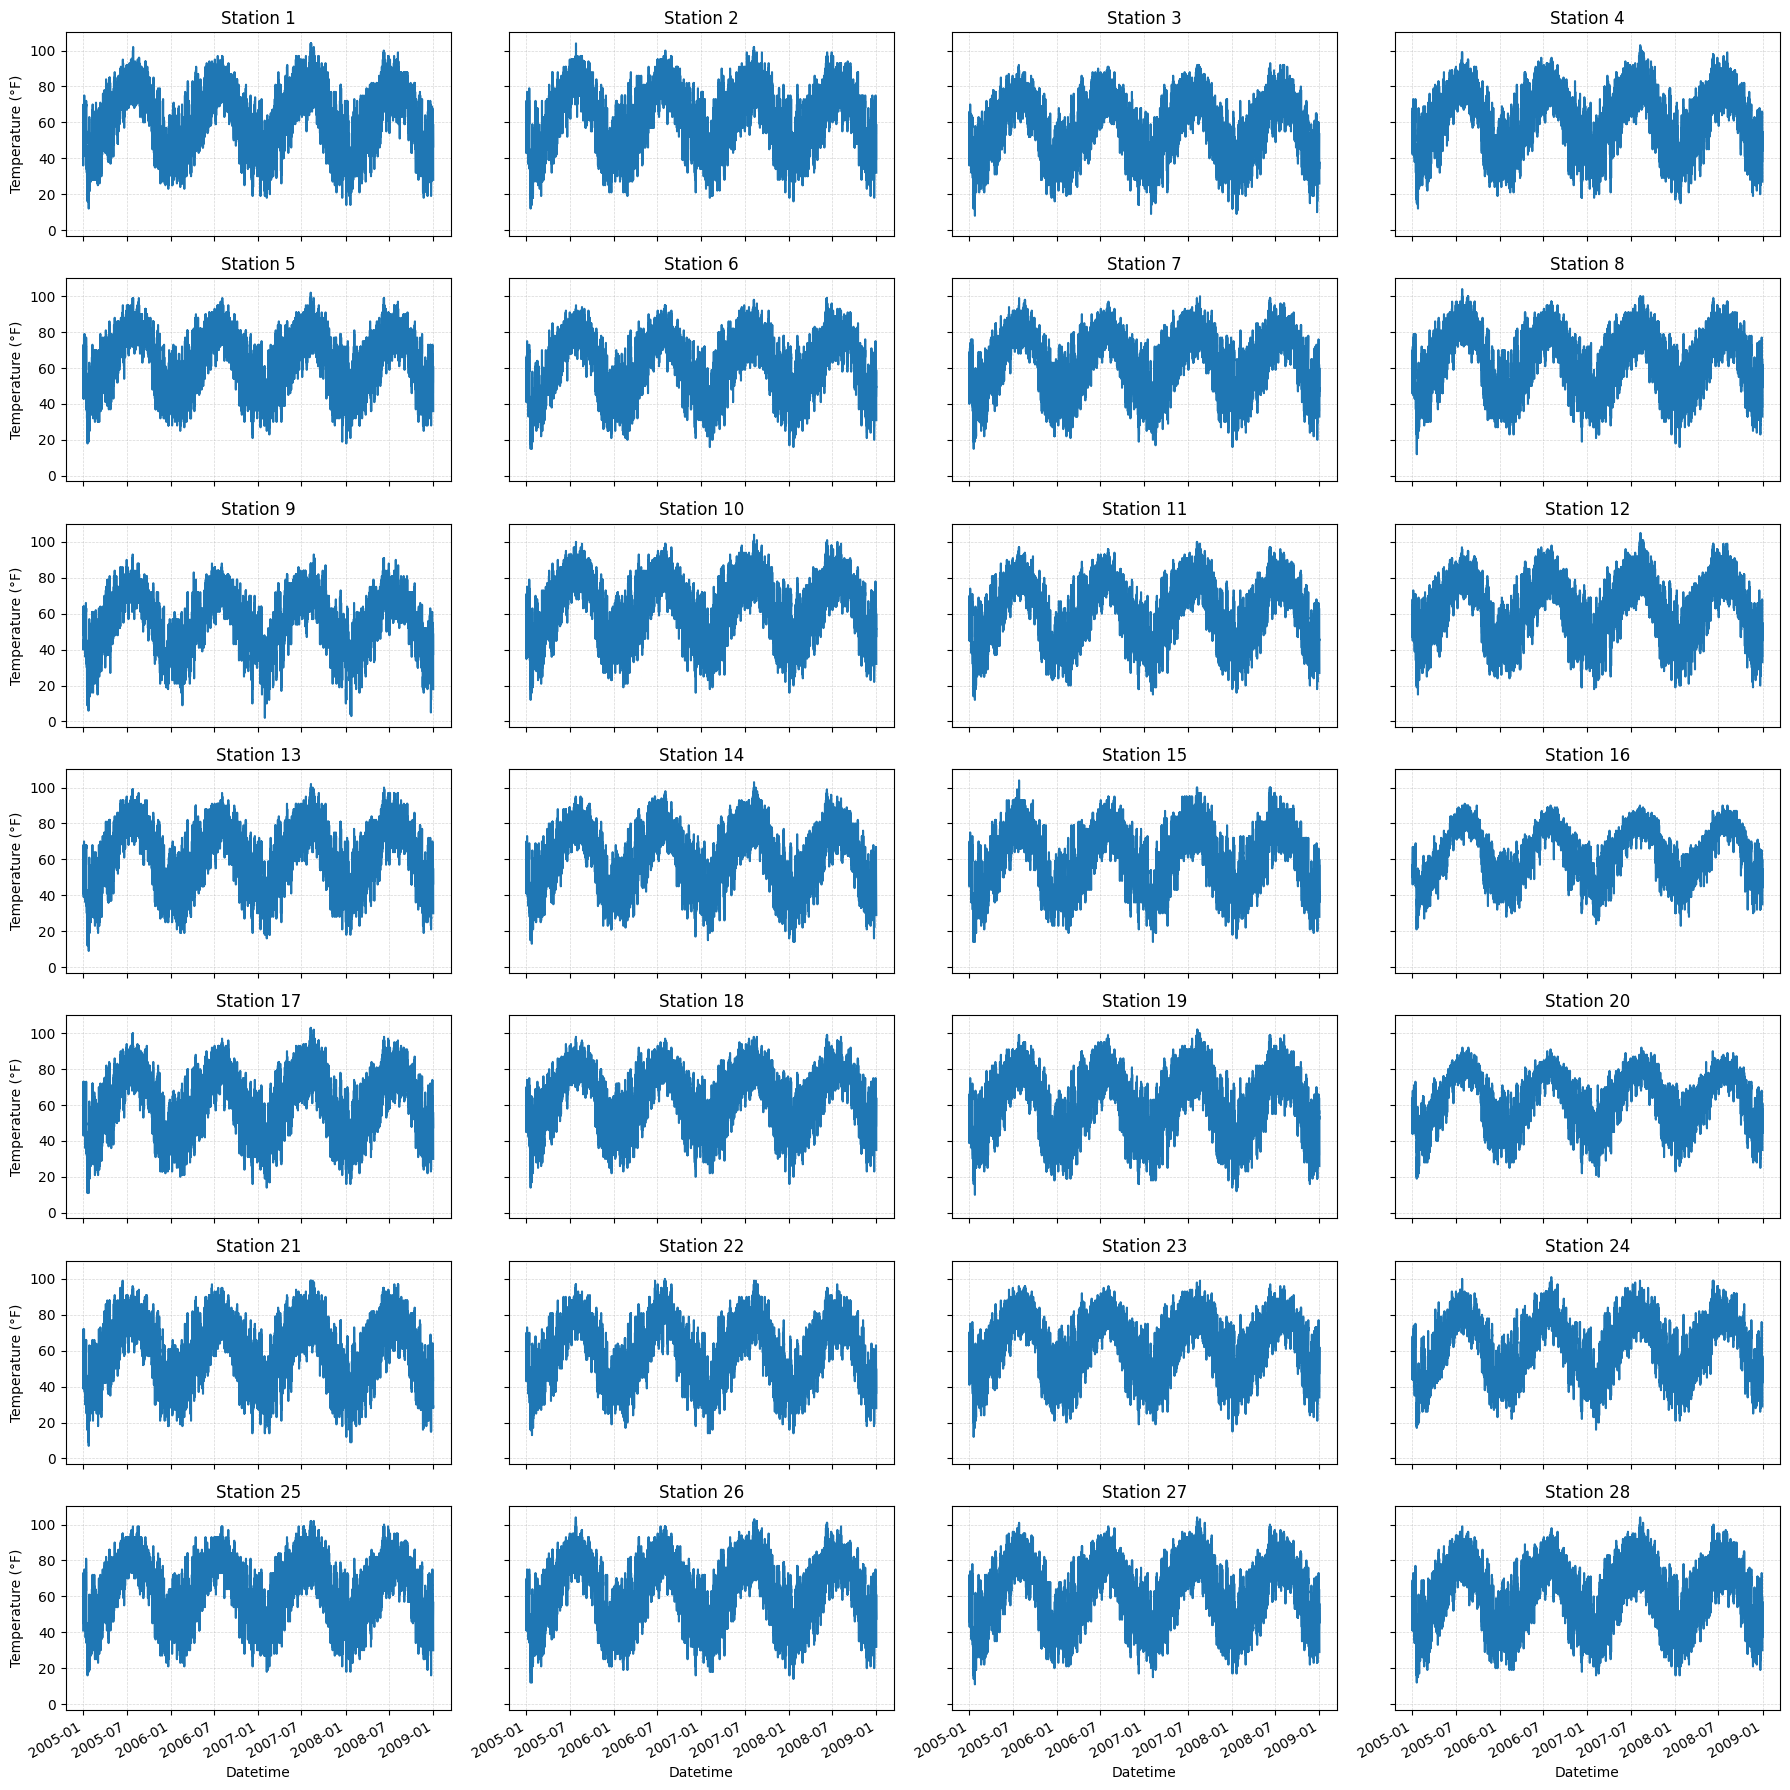

In [31]:
fig, ax = plt.subplots(7,4, figsize=(18, 18), sharex=True, sharey=True)

for i, station in enumerate(weather_pivot.columns):
    axi = ax[i//4, i%4]
    sns.lineplot(data=weather_pivot, x=weather_pivot.index, y=station, ax=axi)
    axi.set_title(station)
    axi.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
    axi.set_ylabel("Temperature (°F)")

plt.gcf().autofmt_xdate()
plt.tight_layout()

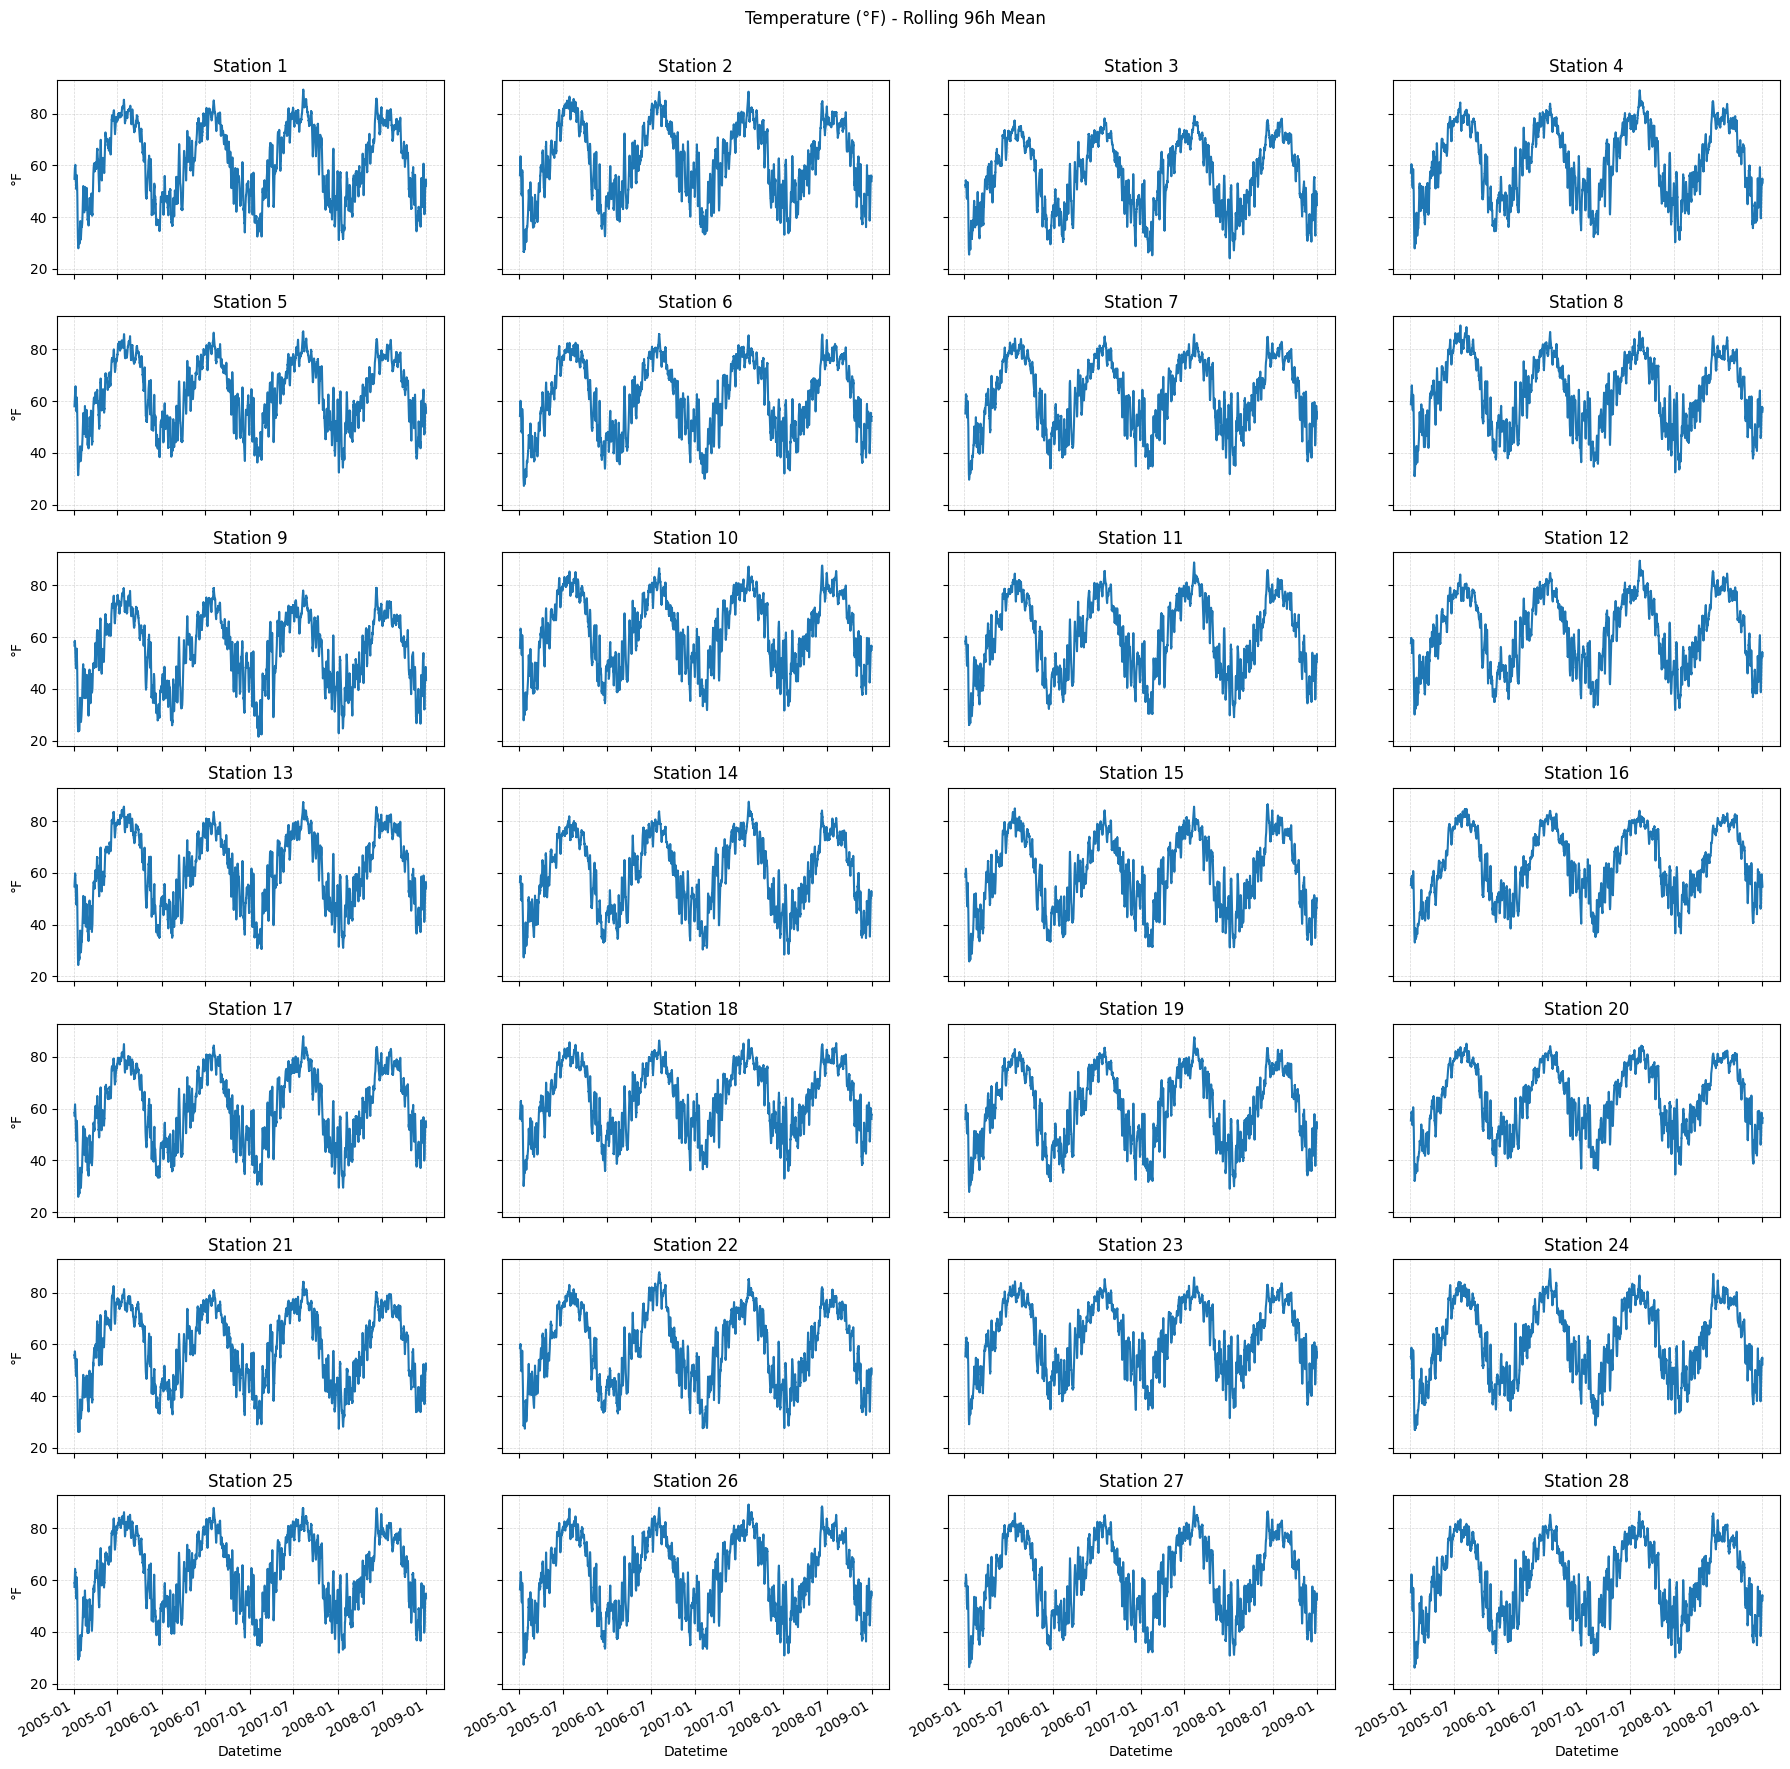

In [32]:
fig, ax = plt.subplots(7, 4, figsize=(18, 18), sharex=True, sharey=True)

for i, station in enumerate(weather_pivot.columns):
    axi = ax[i // 4, i % 4]
    sns.lineplot(data=weather_pivot.rolling(window=window).mean(), x=weather_pivot.index, y=station, ax=axi)
    axi.set_title(station)
    axi.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
    axi.set_ylabel("°F")

fig.suptitle(f"Temperature (°F) - Rolling {window}h Mean")

plt.gcf().autofmt_xdate()
plt.tight_layout(rect=[0, 0, 1, 0.98])

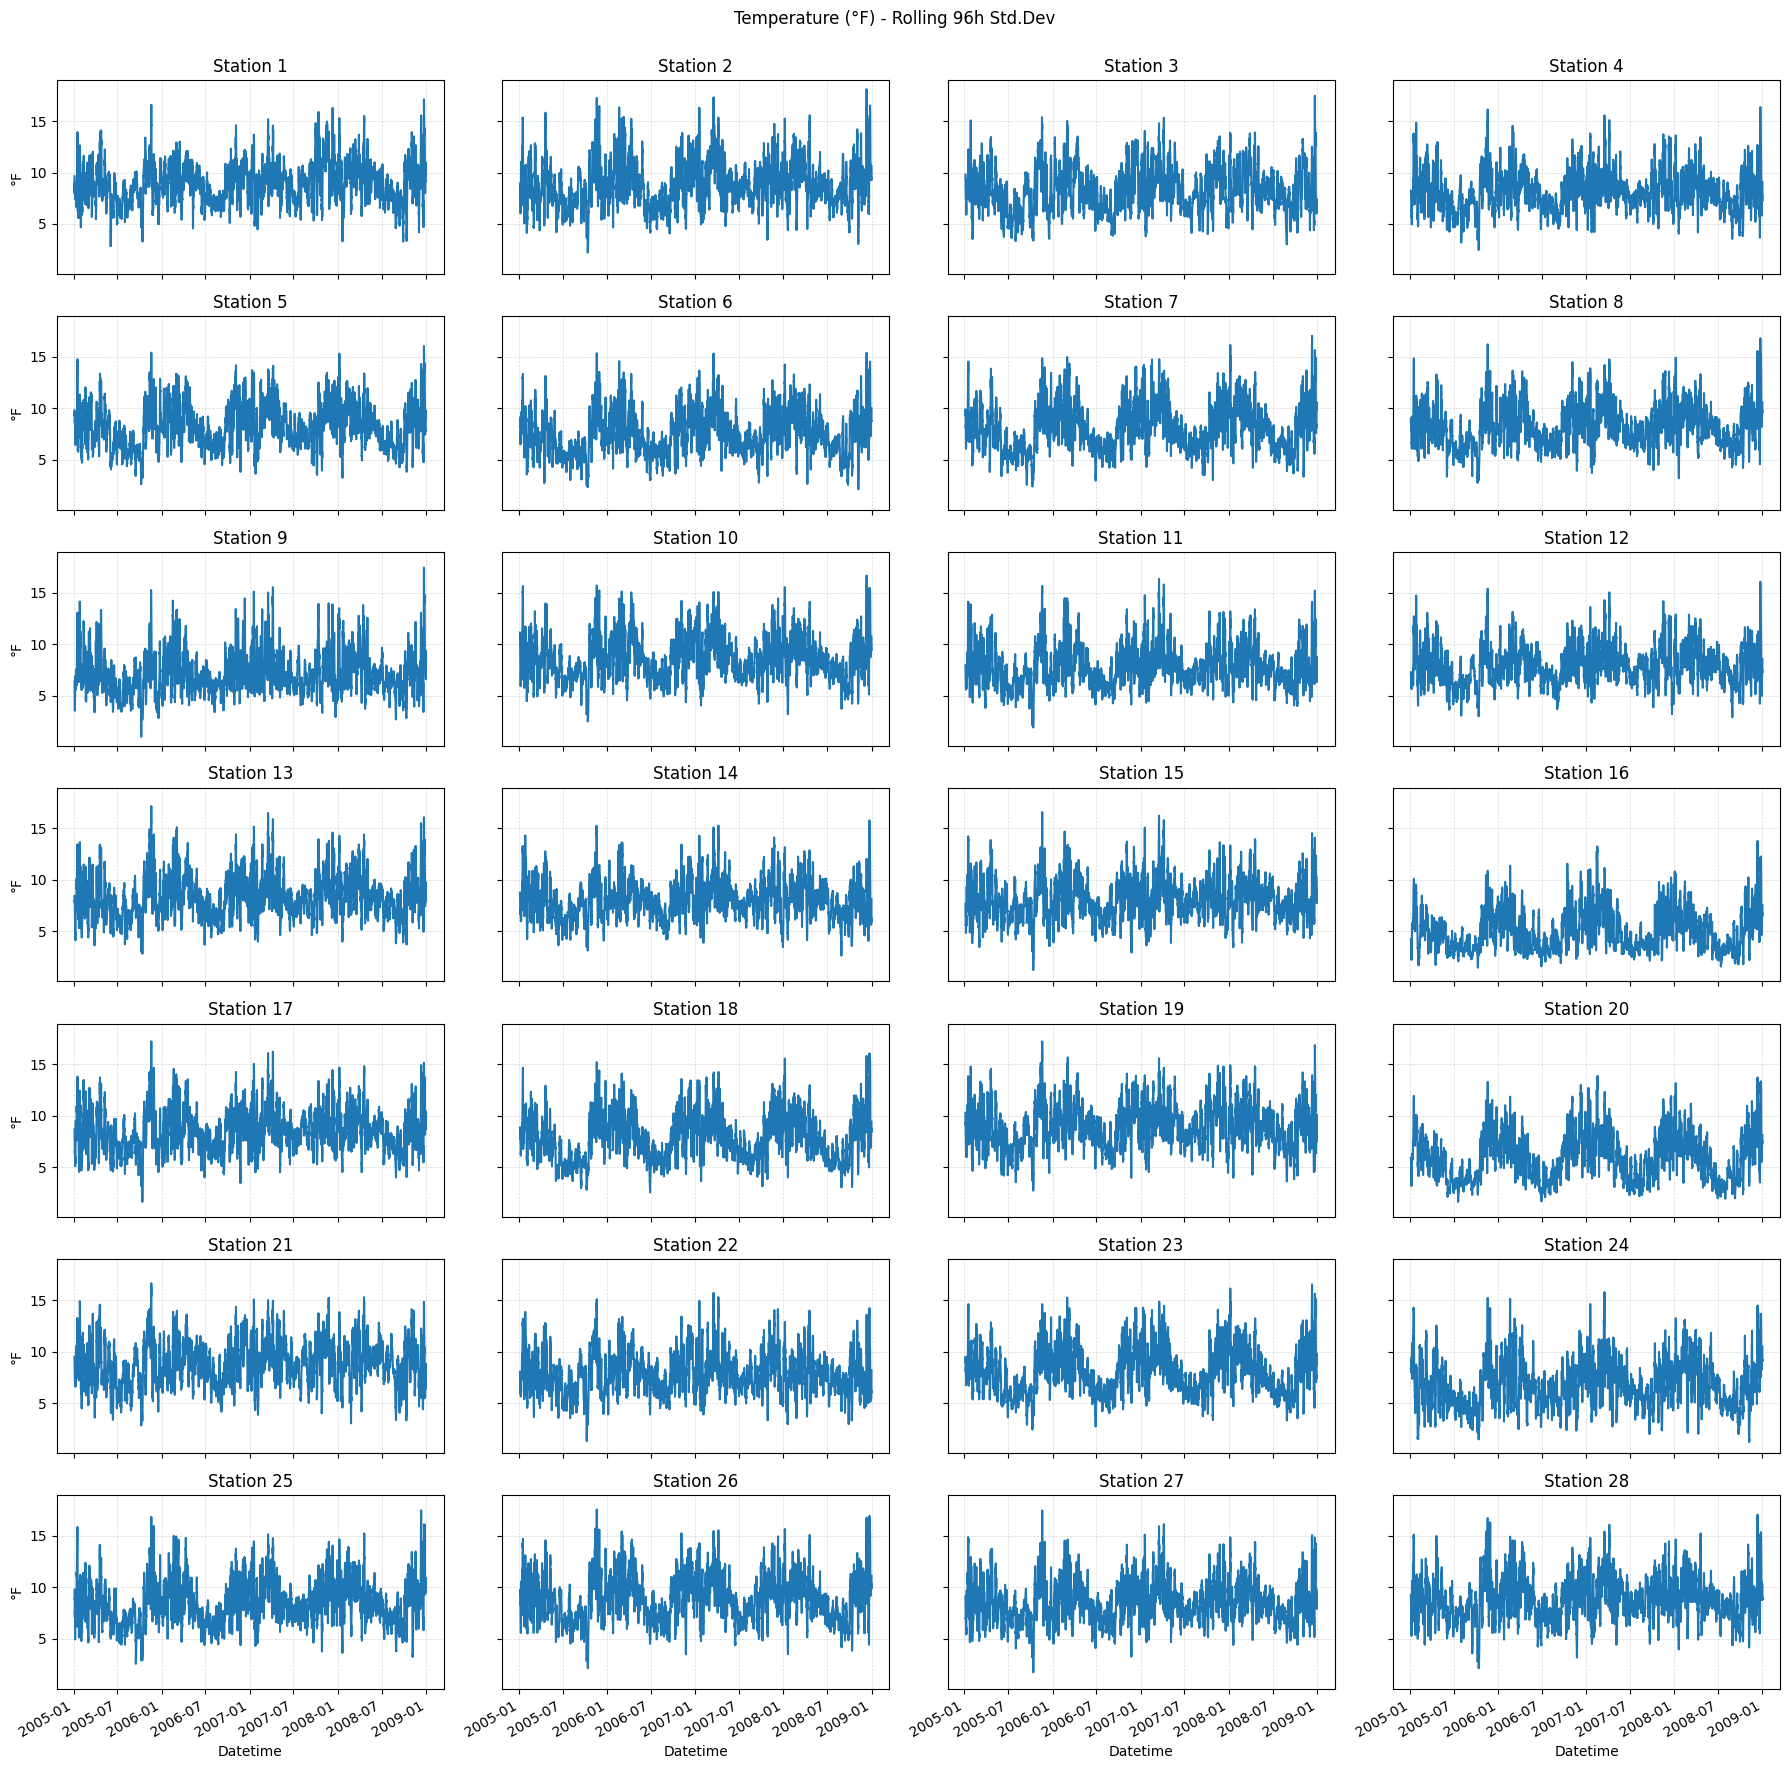

In [33]:
fig, ax = plt.subplots(7, 4, figsize=(18, 18), sharex=True, sharey=True)

for i, station in enumerate(weather_pivot.columns):
    axi = ax[i // 4, i % 4]
    sns.lineplot(
        data=weather_pivot.rolling(window=window).std(),
        x=weather_pivot.index,
        y=station,
        ax=axi,
    )
    axi.set_title(station)
    axi.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
    axi.set_ylabel("°F")

fig.suptitle(f"Temperature (°F) - Rolling {window}h Std.Dev")

plt.gcf().autofmt_xdate()
plt.tight_layout(rect=[0, 0, 1, 0.98])


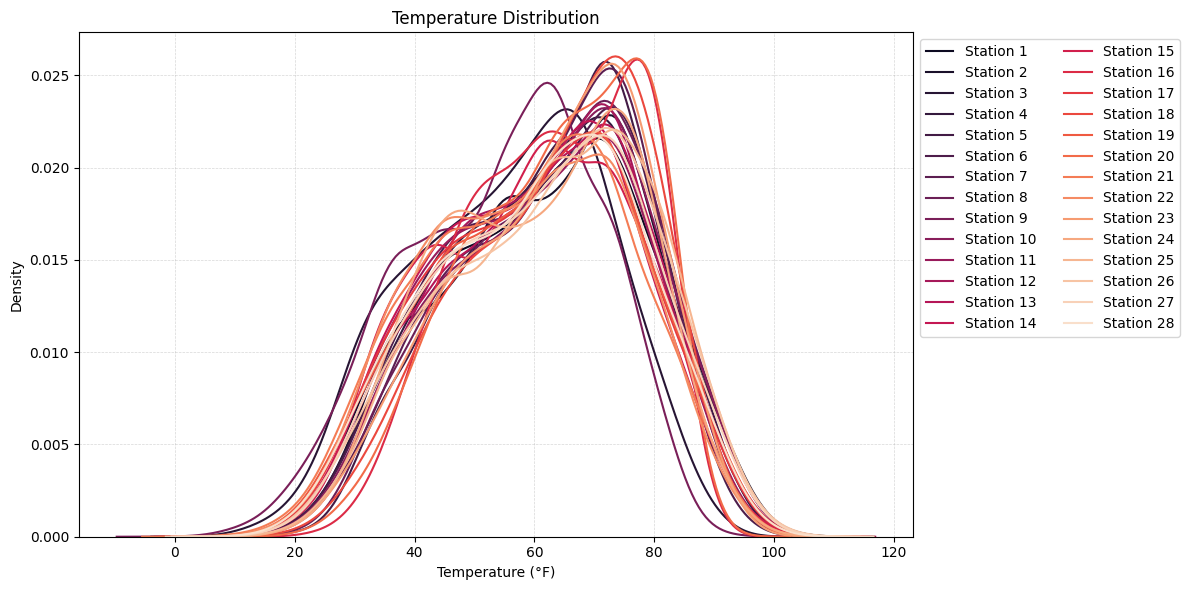

In [34]:
fig, ax = plt.subplots(figsize=(12, 6))

palette = sns.color_palette("rocket", 28)

for i, station in enumerate(weather_pivot.columns):
    sns.kdeplot(data=weather_pivot, x=station, ax=ax, label=station, color=palette[i], bw_adjust=2)

ax.set_title("Temperature Distribution")
ax.set_xlabel("Temperature (°F)")
ax.legend(ncols=2, bbox_to_anchor=(1, 1))
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
plt.tight_layout()

In [35]:
# Check for Nan values
for i, station in enumerate(weather_pivot.columns):
    print(f"Station {station}: Nans: {weather_pivot[station].isna().sum()}")

Station Station 1: Nans: 0
Station Station 2: Nans: 0
Station Station 3: Nans: 0
Station Station 4: Nans: 0
Station Station 5: Nans: 0
Station Station 6: Nans: 0
Station Station 7: Nans: 0
Station Station 8: Nans: 0
Station Station 9: Nans: 0
Station Station 10: Nans: 0
Station Station 11: Nans: 0
Station Station 12: Nans: 0
Station Station 13: Nans: 0
Station Station 14: Nans: 0
Station Station 15: Nans: 0
Station Station 16: Nans: 0
Station Station 17: Nans: 0
Station Station 18: Nans: 0
Station Station 19: Nans: 0
Station Station 20: Nans: 0
Station Station 21: Nans: 0
Station Station 22: Nans: 0
Station Station 23: Nans: 0
Station Station 24: Nans: 0
Station Station 25: Nans: 0
Station Station 26: Nans: 0
Station Station 27: Nans: 0
Station Station 28: Nans: 0


In [36]:
# Check for missing datetimes
weather_full_range = pd.date_range(
    start=weather.index.min(), end=weather.index.max(), freq="h"
)
weather_missing_datetimes = weather_full_range.difference(weather_pivot.index)
print(f"Missing datetimes: {weather_missing_datetimes}")
# Daylight Saving Time (DST) transition

Missing datetimes: DatetimeIndex(['2005-04-03 01:00:00', '2006-04-02 01:00:00',
               '2007-03-11 01:00:00', '2008-03-09 01:00:00'],
              dtype='datetime64[ns]', freq=None)


In [37]:
# Check for duplicated datetimes
weather_duplicated_datetimes = weather_pivot.index[weather_pivot.index.duplicated()]
print(f"Duplicated datetimes: {weather_duplicated_datetimes}")
# Daylight Saving Time (DST) transition (averaged by pivot)

Duplicated datetimes: DatetimeIndex([], dtype='datetime64[ns]', name='Datetime', freq=None)


In [38]:
# Get description of the data
weather_pivot.describe().T

count       mean        std   min   25%   50%   75%    max
Station 1   35060.0  61.215088  16.995040  12.0  48.0  63.0  74.0  104.0
Station 2   35060.0  61.860011  16.768754  12.0  48.0  63.0  75.0  104.0
Station 3   35060.0  55.671535  16.084260   8.0  43.0  57.0  68.0   93.0
Station 4   35060.0  61.197362  16.249025  12.0  49.0  63.0  74.0  103.0
Station 5   35060.0  63.216244  15.344094  18.0  52.0  64.0  75.0  102.0
Station 6   35060.0  60.912607  15.959678  15.0  48.0  63.0  74.0   99.0
Station 7   35060.0  62.354364  15.725955  15.0  50.0  65.0  75.0  100.0
Station 8   35060.0  63.244467  15.953834  12.0  52.0  64.0  75.0  104.0
Station 9   35060.0  54.428280  15.795368   2.0  43.0  57.0  66.0   93.0
Station 10  35060.0  62.349073  16.467500  12.0  50.0  64.0  75.0  104.0
Station 11  35060.0  60.108585  16.634297  12.0  47.0  61.0  73.0  100.0
Station 12  35060.0  61.659926  16.038854  15.0  49.0  63.0  74.0  105.0
Station 13  35060.0  61.070622  16.682206   9.0  48.0  63.0  73.0  102.0
Station 14  35060.0  59.513776  16.370896  13.0  47.0  61.0  72.0  103.0
Station 15  35060.0  59.550371  16.540072  14.0  45.0  61.0  73.0  104.0
Station 16  35060.0  63.288605  14.021824  21.0  52.0  64.0  76.0   91.0
Station 17  35060.0  60.049772  16.763814  11.0  47.0  62.0  73.0  103.0
Station 18  35060.0  63.790245  15.258554  14.0  52.0  66.0  76.0   99.0
Station 19  35060.0  60.243953  16.909042  10.0  46.0  63.0  73.0  102.0
Station 20  35060.0  63.608357  14.386518  19.0  53.0  65.0  76.0   92.0
Station 21  35060.0  58.646192  16.823909   7.0  46.0  61.0  72.0   99.0
Station 22  35060.0  58.733214  16.606777  13.0  45.0  61.0  72.0  100.0
Station 23  35060.0  62.824544  15.569694  12.0  51.0  65.0  75.0   99.0
Station 24  35060.0  60.990630  16.078798  16.0  48.0  62.0  74.0  101.0
Station 25  35060.0  62.930590  16.542554  16.0  51.0  64.0  75.0  102.0
Station 26  35060.0  62.229378  17.053197  12.0  49.0  64.0  75.0  104.0
Station 27  35060.0  61.238719  16.874078  11.0  48.0  63.0  74.0  104.0
Station 28  35060.0  60.378080  16.867967  12.0  47.0  62.0  73.0  104.0

### Check Correlation with Load

In [39]:
corr_df = pd.merge(weather_pivot, load_analysis["Load"], left_index=True, right_index=True, how="inner")

In [40]:
pearson_corr = corr_df.corr(method="pearson")["Load"].sort_values(ascending=False)
spearm_corr = corr_df.corr(method="spearman")["Load"].sort_values(ascending=False)

In [41]:
mutual_info = mutual_info_regression(
    corr_df.drop(columns="Load"), corr_df["Load"], n_neighbors=5
)

In [42]:
predps = pps.predictors(corr_df, "Load")

In [43]:
results = pd.DataFrame(
    {
        "Pearson": pearson_corr,
        "Spearman": spearm_corr,
        "Mutual Info": np.append(1.0, mutual_info),
        "PPS": np.append(1.0, predps["ppscore"].to_numpy()),
    }
)

In [44]:
# Compare multiple correlation metrics
results.sort_values("Mutual Info", ascending=False)

Pearson  Spearman  Mutual Info       PPS
Load        1.000000  1.000000     1.000000  1.000000
Station 19  0.161183  0.125372     0.599586  0.371492
Station 21  0.159240  0.119477     0.576361  0.352261
Station 12  0.152472  0.117213     0.565210  0.391867
Station 26  0.143660  0.127071     0.536407  0.327797
Station 2   0.155156  0.124727     0.527477  0.365432
Station 8   0.141970  0.114889     0.526577  0.251367
Station 24  0.134600  0.098168     0.515537  0.335030
Station 20  0.085626  0.094942     0.511321  0.358590
Station 7   0.119046  0.117252     0.501441  0.278577
Station 1   0.175197  0.136343     0.498154  0.422546
Station 3   0.151351  0.127328     0.494280  0.287503
Station 22  0.167569  0.117060     0.469371  0.346874
Station 28  0.156452  0.122061     0.462439  0.307532
Station 11  0.150134  0.117212     0.460615  0.405134
Station 18  0.108018  0.118350     0.450394  0.371585
Station 9   0.118405  0.103019     0.446552  0.218499
Station 6   0.126357  0.106725     0.431054  0.282927
Station 16  0.103501  0.085755     0.411111  0.383389
Station 17  0.160121  0.117878     0.408403  0.376598
Station 13  0.139487  0.115851     0.388771  0.385728
Station 10  0.150742  0.130471     0.377774  0.416836
Station 25  0.143779  0.126061     0.366881  0.330705
Station 4   0.152718  0.122398     0.365512  0.287441
Station 14  0.161058  0.120394     0.363836  0.384899
Station 5   0.145988  0.125416     0.362680  0.286574
Station 15  0.160950  0.117047     0.361022  0.383545
Station 27  0.157472  0.123478     0.321309  0.316480
Station 23  0.111675  0.119609     0.278980  0.343735

In [45]:
worst_stations = results[results["Mutual Info"] <= 0.4].index.to_list()

In [46]:
# PPS matrix
matrix_df = pps.matrix(corr_df)[["x", "y", "ppscore"]].pivot(
    columns="x", index="y", values="ppscore"
)

Text(0.5, 1.0, 'PPS Matrix')

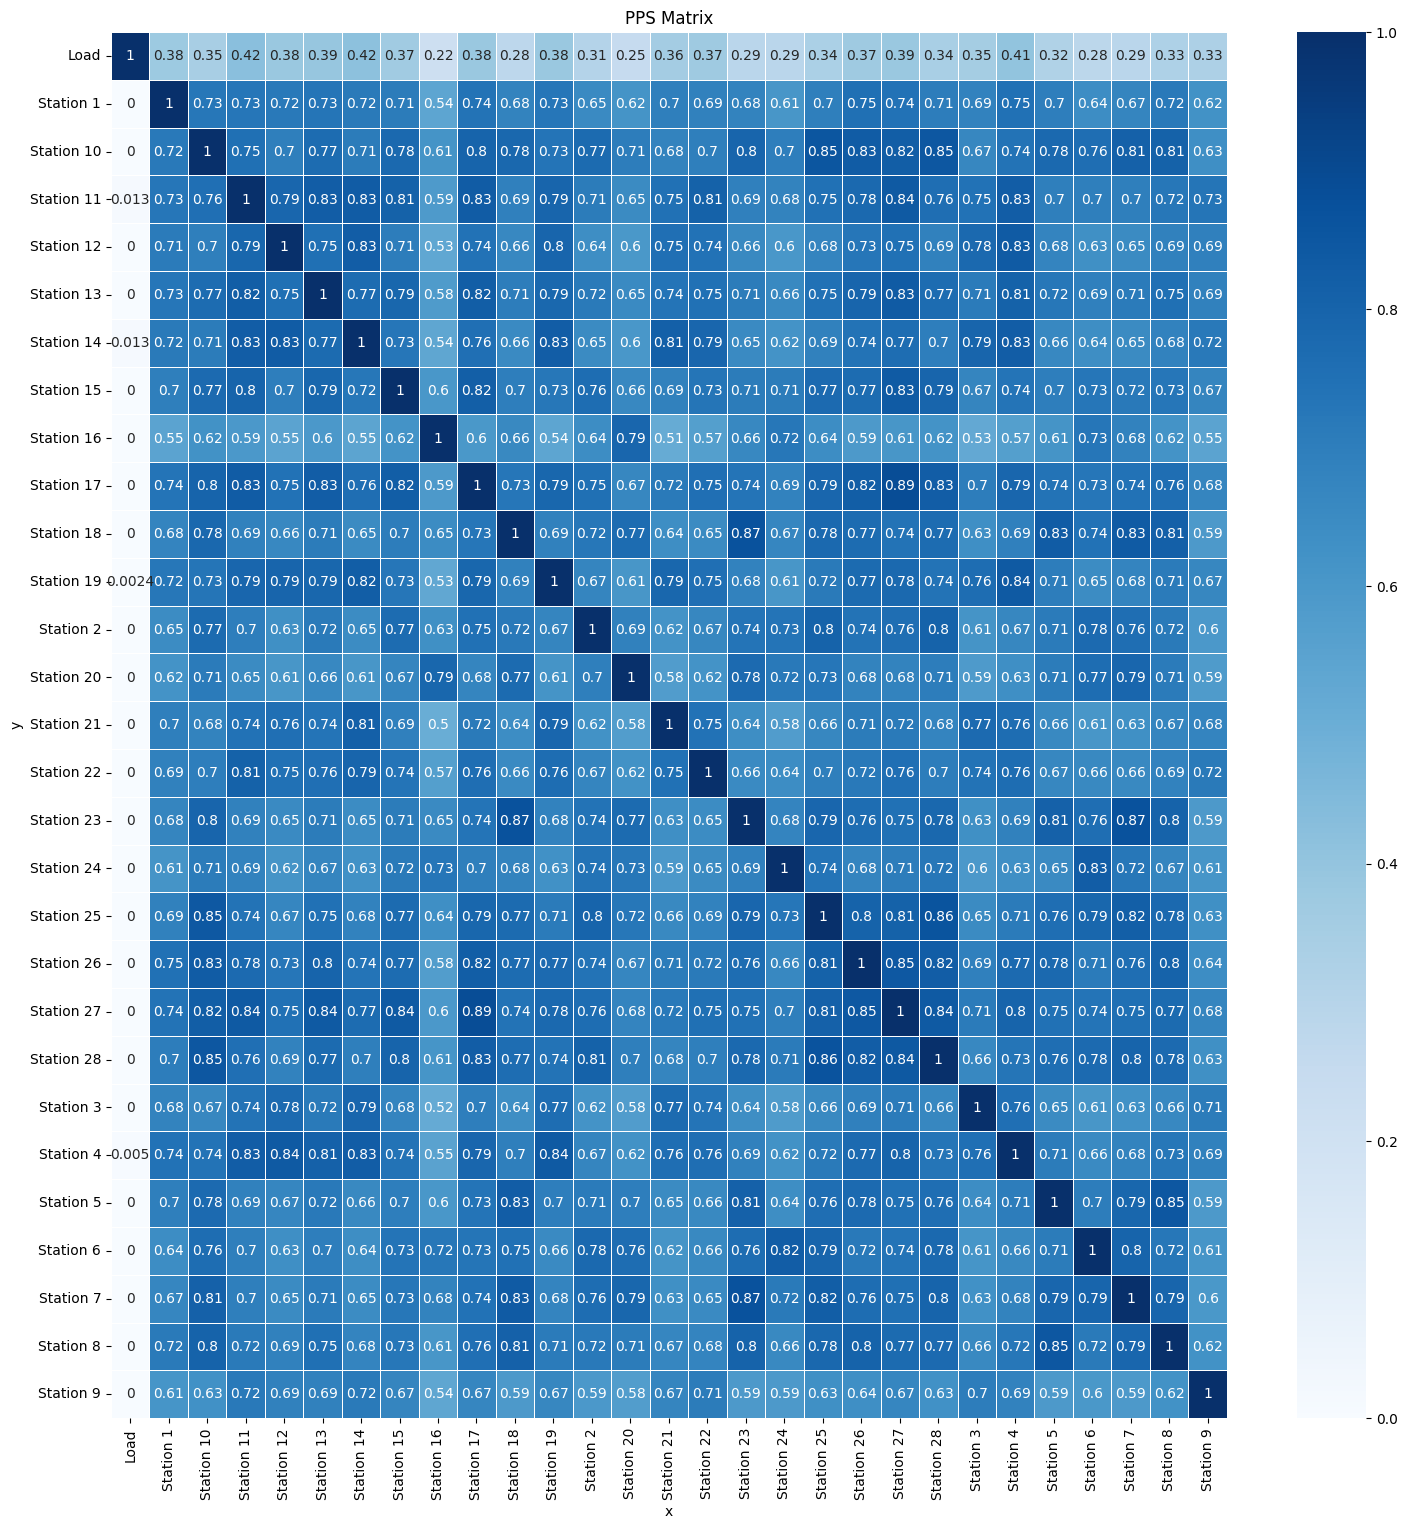

In [47]:
fig, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True, ax=ax)
ax.set_title("PPS Matrix")

In [48]:
# Cross-correlation of the time series
cross_corr = {}
for station in weather_pivot.columns:
    cross_corr[station] = ccf(corr_df["Load"], corr_df[station], nlags=window)
cross_corr = pd.DataFrame(cross_corr, index=range(window))

In [49]:
# Cross-correlation of the time series with shifts
corr_shift = corr_df.copy()
shifts = cross_corr.iloc[:12].idxmax().to_dict()
for c, val in shifts.items():
    corr_shift[c] = corr_shift[c].shift(val)
corr_shift.bfill(inplace=True)

In [50]:
cross_corr_shift = {}
for station in weather_pivot.columns:
    cross_corr_shift[station] = ccf(
        corr_shift["Load"], corr_shift[station], nlags=window
    )
cross_corr_shift = pd.DataFrame(cross_corr_shift, index=range(window))

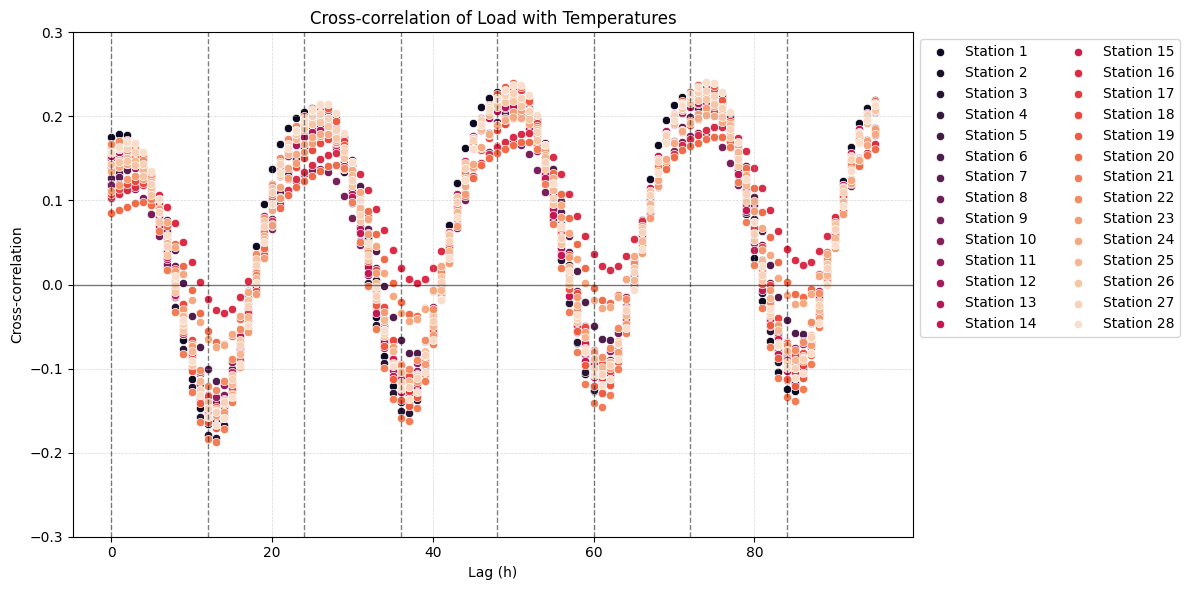

In [51]:
fig, ax = plt.subplots(figsize=(12, 6))

for i, station in enumerate(weather_pivot.columns):
    sns.scatterplot(data=cross_corr[station], ax=ax, label=station, color=palette[i])

ax.set_xlabel("Lag (h)")
ax.set_ylabel("Cross-correlation")
ax.legend(ncols=2, bbox_to_anchor=(1, 1))
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
for t in range(8):
    ax.axvline(x=t*12, color='k', linestyle='--', linewidth=1., alpha=0.5)

ax.axhline(y=0, color='k', linestyle='-', linewidth=1., alpha=0.5)
ax.set_ylim(-0.3, 0.3)
ax.set_title("Cross-correlation of Load with Temperatures")
plt.tight_layout()

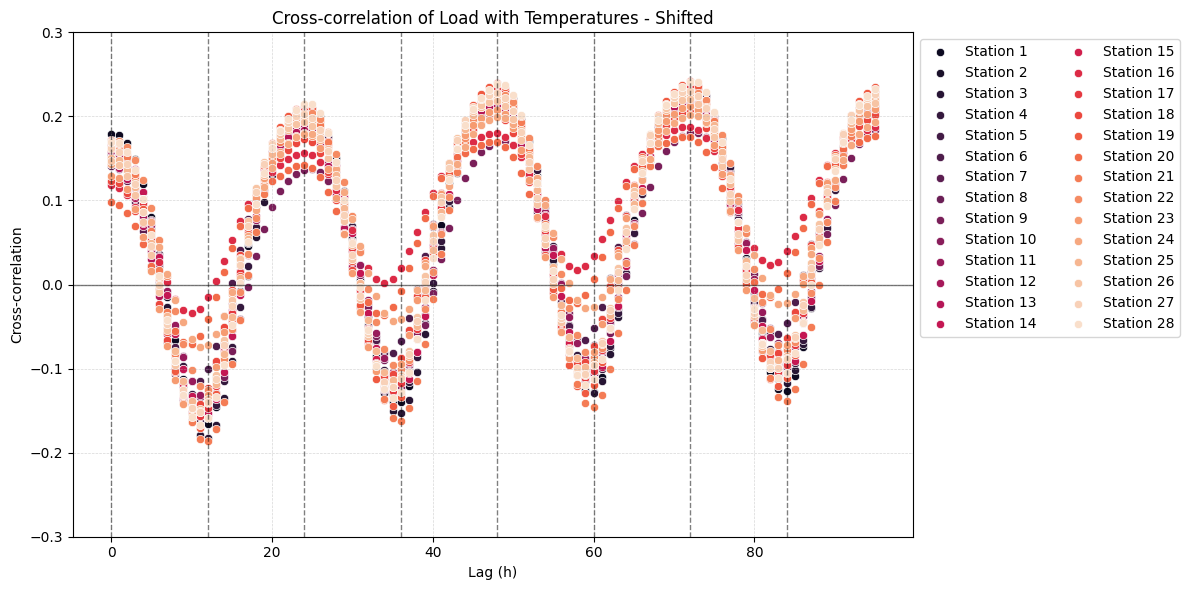

In [52]:
fig, ax = plt.subplots(figsize=(12, 6))

for i, station in enumerate(weather_pivot.columns):
    sns.scatterplot(data=cross_corr_shift[station], ax=ax, label=station, color=palette[i])

ax.set_xlabel("Lag (h)")
ax.set_ylabel("Cross-correlation")
ax.legend(ncols=2, bbox_to_anchor=(1, 1))
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
for t in range(8):
    ax.axvline(x=t * 12, color="k", linestyle="--", linewidth=1.0, alpha=0.5)

ax.axhline(y=0, color="k", linestyle="-", linewidth=1.0, alpha=0.5)
ax.set_ylim(-0.3, 0.3)
ax.set_title("Cross-correlation of Load with Temperatures - Shifted")
plt.tight_layout()

In [53]:
# Add lagged features to correlation df
corr_df_lagged = corr_df.copy()
for station in [f"Station {i+1}" for i in range(28)]:
    for i in range(1, window+1):
        corr_df_lagged[f"{station}_lag_{i}"] = weather_pivot[station].shift(i)

In [54]:
# PPS of lagged features
lagpredps = pps.predictors(corr_df_lagged, "Load")

In [55]:
lagpredps.sort_values("ppscore", ascending=False).head()

x     y   ppscore        case  is_valid_score  \
0  Station 11_lag_1  Load  0.475122  regression            True   
1   Station 4_lag_1  Load  0.470229  regression            True   
2  Station 11_lag_2  Load  0.470214  regression            True   
3   Station 4_lag_2  Load  0.468665  regression            True   
4  Station 14_lag_1  Load  0.465139  regression            True   

                metric  baseline_score  model_score                    model  
0  mean absolute error        251.2570   131.879150  DecisionTreeRegressor()  
1  mean absolute error        251.2570   133.108774  DecisionTreeRegressor()  
2  mean absolute error        249.4504   132.155266  DecisionTreeRegressor()  
3  mean absolute error        249.4504   132.541850  DecisionTreeRegressor()  
4  mean absolute error        251.2570   134.387633  DecisionTreeRegressor()

In [56]:
# Selection of best Stations for lagged features based on PPS
# Choose the top 5 stations for each lag around hour 0, 12 and 24
nlags = 4
columns_feateng = {}
for i in [0, 12, 24]: 
    cross_corr_rows = cross_corr.iloc[i:i+4]
    top_5_columns_per_row = cross_corr_rows.apply(
        lambda row: list(row.nlargest(5).index), axis=1
    )
    selected_columns = np.unique(
        [col for sublist in top_5_columns_per_row for col in sublist]
    )
    columns_feateng[f"{i}"] = selected_columns

In [57]:
# Add rolling features to correlation df
corr_df_rolling = corr_df.copy()
for station in [f"Station {i+1}" for i in range(28)]:
    for i in range(1, 6):
        corr_df_rolling[f"{station}_roll_{i}_mean"] = weather_pivot[station].rolling(window=i).mean()
        corr_df_rolling[f"{station}_roll_{i}_min"] = (
            weather_pivot[station].rolling(window=i).min()
        )
        corr_df_rolling[f"{station}_roll_{i}_max"] = (
            weather_pivot[station].rolling(window=i).max()
        )


In [58]:
# PPS of rolling features
rollpredps = pps.predictors(corr_df_rolling, "Load")

In [59]:
rollpredps.sort_values("ppscore", ascending=False).head(20)

x     y   ppscore        case  is_valid_score  \
0     Station 4_roll_4_max  Load  0.482105  regression            True   
1    Station 11_roll_3_max  Load  0.479942  regression            True   
2    Station 14_roll_4_max  Load  0.478384  regression            True   
3    Station 11_roll_4_max  Load  0.476314  regression            True   
4    Station 19_roll_4_max  Load  0.475914  regression            True   
5    Station 4_roll_3_mean  Load  0.475696  regression            True   
6    Station 14_roll_3_max  Load  0.475319  regression            True   
7   Station 11_roll_4_mean  Load  0.474229  regression            True   
8     Station 4_roll_3_max  Load  0.473369  regression            True   
9   Station 11_roll_3_mean  Load  0.472477  regression            True   
10   Station 4_roll_4_mean  Load  0.471741  regression            True   
11  Station 14_roll_4_mean  Load  0.471138  regression            True   
12    Station 4_roll_5_max  Load  0.471072  regression            True   
13  Station 14_roll_3_mean  Load  0.471062  regression            True   
14  Station 19_roll_4_mean  Load  0.469744  regression            True   
15   Station 19_roll_5_max  Load  0.464990  regression            True   
16   Station 11_roll_3_min  Load  0.464239  regression            True   
17   Station 17_roll_4_max  Load  0.463595  regression            True   
18  Station 19_roll_5_mean  Load  0.462778  regression            True   
19    Station 4_roll_3_min  Load  0.460991  regression            True   

                 metric  baseline_score  model_score                    model  
0   mean absolute error        246.6094   127.717722  DecisionTreeRegressor()  
1   mean absolute error        249.4504   129.728554  DecisionTreeRegressor()  
2   mean absolute error        246.6094   128.635389  DecisionTreeRegressor()  
3   mean absolute error        246.6094   129.145990  DecisionTreeRegressor()  
4   mean absolute error        246.6094   129.244608  DecisionTreeRegressor()  
5   mean absolute error        249.4504   130.787823  DecisionTreeRegressor()  
6   mean absolute error        249.4504   130.881797  DecisionTreeRegressor()  
7   mean absolute error        246.6094   129.660121  DecisionTreeRegressor()  
8   mean absolute error        249.4504   131.368397  DecisionTreeRegressor()  
9   mean absolute error        249.4504   131.590805  DecisionTreeRegressor()  
10  mean absolute error        246.6094   130.273732  DecisionTreeRegressor()  
11  mean absolute error        246.6094   130.422368  DecisionTreeRegressor()  
12  mean absolute error        245.9952   130.113639  DecisionTreeRegressor()  
13  mean absolute error        249.4504   131.943825  DecisionTreeRegressor()  
14  mean absolute error        246.6094   130.766053  DecisionTreeRegressor()  
15  mean absolute error        245.9952   131.609937  DecisionTreeRegressor()  
16  mean absolute error        249.4504   133.645893  DecisionTreeRegressor()  
17  mean absolute error        246.6094   132.282463  DecisionTreeRegressor()  
18  mean absolute error        245.9952   132.154095  DecisionTreeRegressor()  
19  mean absolute error        249.4504   134.455964  DecisionTreeRegressor()

In [60]:
# Selection of best Stations for rolling features based on PPS
columns_feateng["roll"] = ["Station 4", "Station 11", "Station 14", "Station 19", "Station 17"]

In [61]:
# Add lead features to correlation df
corr_df_lead = corr_df.copy()
for station in [f"Station {i+1}" for i in range(28)]:
    for i in range(1, 13):
        corr_df_lead[f"{station}_lead_{i}"] = weather_pivot[station].shift(-i)


In [62]:
# PPS of lead features
leadpredps = pps.predictors(corr_df_lead, "Load")

In [63]:
leadpredps.sort_values("ppscore", ascending=False).head(20)

x     y   ppscore        case  is_valid_score  \
0          Station 11  Load  0.422546  regression            True   
1          Station 14  Load  0.416836  regression            True   
2           Station 4  Load  0.405134  regression            True   
3          Station 13  Load  0.391867  regression            True   
4          Station 27  Load  0.385728  regression            True   
5          Station 12  Load  0.384899  regression            True   
6          Station 19  Load  0.383545  regression            True   
7          Station 17  Load  0.383389  regression            True   
8           Station 1  Load  0.376598  regression            True   
9          Station 22  Load  0.371585  regression            True   
10         Station 26  Load  0.371492  regression            True   
11         Station 15  Load  0.365432  regression            True   
12         Station 21  Load  0.358590  regression            True   
13          Station 3  Load  0.352261  regression            True   
14         Station 10  Load  0.346874  regression            True   
15         Station 28  Load  0.343735  regression            True   
16  Station 11_lead_1  Load  0.343100  regression            True   
17         Station 25  Load  0.335030  regression            True   
18          Station 9  Load  0.330705  regression            True   
19  Station 14_lead_1  Load  0.330125  regression            True   

                 metric  baseline_score  model_score                    model  
0   mean absolute error        251.1604   145.033671  DecisionTreeRegressor()  
1   mean absolute error        251.1604   146.467680  DecisionTreeRegressor()  
2   mean absolute error        251.1604   149.406804  DecisionTreeRegressor()  
3   mean absolute error        251.1604   152.738890  DecisionTreeRegressor()  
4   mean absolute error        251.1604   154.280772  DecisionTreeRegressor()  
5   mean absolute error        251.1604   154.488982  DecisionTreeRegressor()  
6   mean absolute error        251.1604   154.829119  DecisionTreeRegressor()  
7   mean absolute error        251.1604   154.868318  DecisionTreeRegressor()  
8   mean absolute error        251.1604   156.574018  DecisionTreeRegressor()  
9   mean absolute error        251.1604   157.832958  DecisionTreeRegressor()  
10  mean absolute error        251.1604   157.856198  DecisionTreeRegressor()  
11  mean absolute error        251.1604   159.378342  DecisionTreeRegressor()  
12  mean absolute error        251.1604   161.096778  DecisionTreeRegressor()  
13  mean absolute error        251.1604   162.686469  DecisionTreeRegressor()  
14  mean absolute error        251.1604   164.039389  DecisionTreeRegressor()  
15  mean absolute error        251.1604   164.827786  DecisionTreeRegressor()  
16  mean absolute error        251.1604   164.987319  DecisionTreeRegressor()  
17  mean absolute error        251.1604   167.014145  DecisionTreeRegressor()  
18  mean absolute error        251.1604   168.100355  DecisionTreeRegressor()  
19  mean absolute error        251.1604   168.246009  DecisionTreeRegressor()

In [64]:
columns_feateng["lead"] = [
    "Station 11",
    "Station 14",
    "Station 4",
]

## Testing the model 

In [65]:
training_columns, test = estimate_probability(test=True)

2024-10-24 13:13:46.995 | INFO     | estimate_probability:estimate_probability:421 - Reading the data
2024-10-24 13:13:47.801 | INFO     | estimate_probability:estimate_probability:493 - Testing the model
2024-10-24 13:13:47.802 | INFO     | estimate_probability:estimate_probability:497 - Feature engineering training data
2024-10-24 13:13:47.830 | INFO     | estimate_probability:estimate_probability:517 - Feature engineering testing data
2024-10-24 13:13:47.867 | INFO     | estimate_probability:estimate_probability:557 - Training the model
2024-10-24 13:13:52.520 | INFO     | estimate_probability:estimate_probability:575 - Saving the benchmark results
2024-10-24 13:13:52.806 | INFO     | estimate_probability:estimate_probability:578 - Fold 1: Score 231.91763196495276
2024-10-24 13:13:52.807 | INFO     | estimate_probability:estimate_probability:497 - Feature engineering training data
2024-10-24 13:13:52.849 | INFO     | estimate_probability:estimate_probability:517 - Feature engineerin

In [66]:
# Check the training columns
for i, c in enumerate(training_columns):
    print(f"{i+1}. {c}")

1. Station 1
2. Station 2
3. Station 3
4. Station 4
5. Station 5
6. Station 6
7. Station 7
8. Station 8
9. Station 9
10. Station 10
11. Station 11
12. Station 12
13. Station 13
14. Station 14
15. Station 15
16. Station 16
17. Station 17
18. Station 18
19. Station 19
20. Station 20
21. Station 21
22. Station 22
23. Station 23
24. Station 24
25. Station 25
26. Station 26
27. Station 27
28. Station 28
29. Hour
30. Dayofweek
31. sin_Dayofyear
32. Week
33. Month
34. Quarter
35. Year
36. Holiday
37. Station 1_lag_1
38. Station 1_lag_2
39. Station 1_lag_3
40. Station 1_lag_4
41. Station 1_lag_5
42. Station 14_lag_1
43. Station 14_lag_2
44. Station 14_lag_3
45. Station 14_lag_4
46. Station 14_lag_5
47. Station 15_lag_1
48. Station 15_lag_2
49. Station 15_lag_3
50. Station 15_lag_4
51. Station 15_lag_5
52. Station 17_lag_1
53. Station 17_lag_2
54. Station 17_lag_3
55. Station 17_lag_4
56. Station 17_lag_5
57. Station 19_lag_1
58. Station 19_lag_2
59. Station 19_lag_3
60. Station 19_lag_4
61. St

In [67]:
# Slimmer test df for plotting and checks
test_clean = test.drop(columns=training_columns)

Text(0.5, 1.0, 'Peak Load Prediction Inspection')

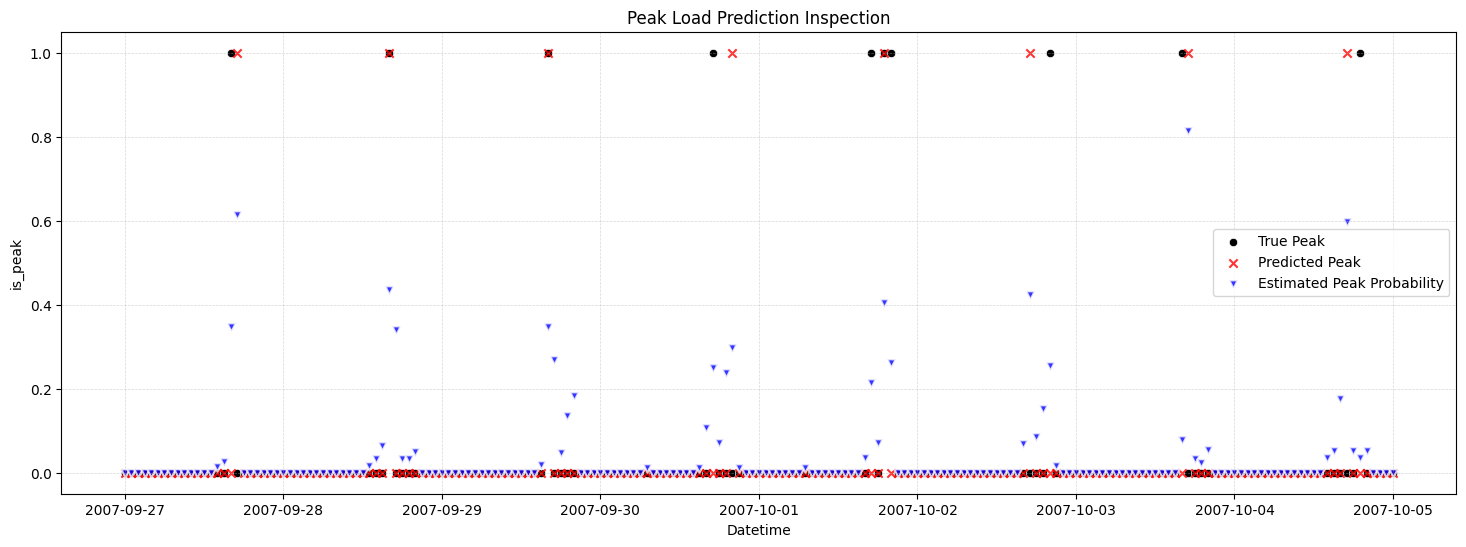

In [68]:
fig, ax = plt.subplots(figsize=(18, 6))

central_date = pd.to_datetime("2007-10-01")
delta = pd.Timedelta("4D")

sns.scatterplot(
    data=test_clean[central_date - delta : central_date + delta],
    x=test_clean[central_date - delta : central_date + delta].index,
    y="is_peak",
    color="black",
    label="True Peak",
    ax=ax,
)
sns.scatterplot(
    data=test_clean[central_date - delta : central_date + delta],
    x=test_clean[central_date - delta : central_date + delta].index,
    y="predicted_is_peak",
    color="red",
    marker="x",
    linewidth=1.5,
    alpha=0.8,
    label="Predicted Peak",
    ax=ax,
)
sns.scatterplot(
    data=test_clean[central_date - delta : central_date + delta],
    x=test_clean[central_date - delta : central_date + delta].index,
    y="normalized_probability",
    color="blue",
    marker="v",
    linewidth=1.5,
    alpha=0.8,
    label="Estimated Peak Probability",
    ax=ax,
)

ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
ax.set_title("Peak Load Prediction Inspection")

# Create Peak Probability Estimation

In [69]:
training_columns, estimate = estimate_probability(test=False)

2024-10-24 13:13:59.574 | INFO     | estimate_probability:estimate_probability:421 - Reading the data
2024-10-24 13:14:00.108 | INFO     | estimate_probability:estimate_probability:586 - Feature engineering full training data
2024-10-24 13:14:00.165 | INFO     | estimate_probability:estimate_probability:628 - Training the model
2024-10-24 13:14:07.222 | INFO     | estimate_probability:estimate_probability:632 - Saving the model
2024-10-24 13:14:07.228 | INFO     | estimate_probability:estimate_probability:637 - Reading the data to estimate
2024-10-24 13:14:07.232 | INFO     | estimate_probability:estimate_probability:642 - Feature engineering forecast data
2024-10-24 13:14:07.379 | INFO     | estimate_probability:estimate_probability:669 - Estimating the probabilities
2024-10-24 13:14:07.443 | INFO     | estimate_probability:estimate_probability:684 - Saving the probability estimates


In [70]:
estimate.head(48)

Date  Hour  Daily Peak Probability
0   01/01/2008     1                0.000000
1   01/01/2008     2                0.000000
2   01/01/2008     3                0.000000
3   01/01/2008     4                0.000000
4   01/01/2008     5                0.000000
5   01/01/2008     6                0.000000
6   01/01/2008     7                0.021053
7   01/01/2008     8                0.578947
8   01/01/2008     9                0.052632
9   01/01/2008    10                0.000000
10  01/01/2008    11                0.000000
11  01/01/2008    12                0.000000
12  01/01/2008    13                0.000000
13  01/01/2008    14                0.000000
14  01/01/2008    15                0.000000
15  01/01/2008    16                0.000000
16  01/01/2008    17                0.000000
17  01/01/2008    18                0.000000
18  01/01/2008    19                0.052632
19  01/01/2008    20                0.105263
20  01/01/2008    21                0.178947
21  01/01/2008    22                0.010526
22  01/01/2008    23                0.000000
23  01/01/2008    24                0.000000
24  01/02/2008     1                0.000000
25  01/02/2008     2                0.000000
26  01/02/2008     3                0.000000
27  01/02/2008     4                0.000000
28  01/02/2008     5                0.000000
29  01/02/2008     6                0.000000
30  01/02/2008     7                0.040000
31  01/02/2008     8                0.528000
32  01/02/2008     9                0.032000
33  01/02/2008    10                0.016000
34  01/02/2008    11                0.008000
35  01/02/2008    12                0.008000
36  01/02/2008    13                0.000000
37  01/02/2008    14                0.000000
38  01/02/2008    15                0.000000
39  01/02/2008    16                0.000000
40  01/02/2008    17                0.000000
41  01/02/2008    18                0.000000
42  01/02/2008    19                0.040000
43  01/02/2008    20                0.152000
44  01/02/2008    21                0.176000
45  01/02/2008    22                0.000000
46  01/02/2008    23                0.000000
47  01/02/2008    24                0.000000